<a href="https://colab.research.google.com/github/gustafbjurstam/ML-retreat-tekmek-2025/blob/main/NN-RNN-SINDy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks, Recurrent Neural Networks, and SINDy for Mechanical Systems

## Learning Objectives

By completing this notebook, you will be able to:

- **Apply neural networks** to learn constitutive material behavior from experimental data
- **Understand when history matters** and select appropriate architectures (feedforward vs recurrent)
- **Implement sparse discovery** to extract interpretable governing equations from data
- **Validate models systematically** using interpolation, extrapolation, and physical constraints
- **Make informed engineering decisions** about method selection based on problem characteristics



---



## Why These Methods Matter in Mechanics

**Real-world challenge**: Material characterization requires expensive experimental campaigns. A single stress-strain curve might involve specialized equipment, careful sample preparation, and hours of testing. For complex materials (hyperelastic rubbers, viscoelastic polymers, composites), traditional approaches require testing at multiple rates, temperatures, and loading paths—potentially hundreds of experiments.

**Traditional limitations**:
- Constitutive models are hand-crafted with parameters fitted to specific datasets
- Extending to new loading conditions requires new experiments and model adjustments
- History-dependent materials (viscoelasticity, plasticity) require differential equations that are difficult to calibrate
- Interpolation between test conditions is often unreliable

**Key insight**: Machine learning can learn material behavior from limited data, but only when combined with proper domain knowledge. Neural networks provide flexible function approximation, recurrent architectures handle history dependence, and sparse identification (SINDy) discovers interpretable governing equations.

**Engineering context**: This matters for:
- Reducing experimental costs in material development
- Creating digital twins of mechanical systems
- Real-time simulation for design optimization
- Predictive maintenance based on material degradation

---
## Physical Background: Stress and Strain Measures

We will work with two stress measures:

**Second Piola-Kirchhoff stress** $S$ [kPa]: Work-conjugate to Green-Lagrange strain, used in large deformation theory

**Cauchy stress** $\sigma$ [kPa]: True stress on deformed configuration

For incompressible materials under uniaxial loading with stretch $\lambda$ [-]:

$$\sigma = \lambda^2 S$$

This relationship is fundamental and will help us validate our models physically.

---
## Structure of This Notebook

We progress through four levels of increasing complexity:

**Level 1**: Hyperelastic material (no history) with clean data → Learn when feedforward networks succeed

**Level 2**: Noisy hyperelastic data → Understand regularization and overfitting

**Level 3**: Viscoelastic material (history-dependent) → Motivate recurrent architectures

**Level 4**: Sparse discovery with SINDy → Extract interpretable governing equations

## Setup: Environment Configuration and Reproducibility

In [46]:
# Complete setup: installs, seeds, FAST toggle, imports (Keras 3)
import os, random, math, warnings, time
warnings.filterwarnings("ignore")

# FAST mode for CPU/CI environments; set FAST=0 for full training
FAST = bool(int(os.environ.get("FAST", "1")))
if FAST:
    print("⚡ FAST mode: reduced datasets, slimmer networks, fewer epochs")
    print("   Set environment variable FAST=0 for full training")
else:
    print("🔬 FULL mode: complete datasets and training")

# Reproducibility: set all random seeds
SEED = 1827
random.seed(SEED)
import numpy as np
np.random.seed(SEED)

# Deep learning stack: Keras 3 (use import keras, not from tensorflow import keras)
import keras
from keras import layers, callbacks, regularizers, Model, Sequential
keras.utils.set_random_seed(SEED)

# Plotting and numerical integration
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Configure matplotlib
plt.rcParams.update({"figure.dpi": 110, "figure.figsize": (10, 6)})

# Install pysindy (only once)
try:
    import pysindy as ps
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pysindy", "--quiet"])
    import pysindy as ps

print(f"✅ Setup complete | Keras version: {keras.__version__}")
print(f"   Random seed: {SEED} | Environment: Colab/Jupyter")

⚡ FAST mode: reduced datasets, slimmer networks, fewer epochs
   Set environment variable FAST=0 for full training
✅ Setup complete | Keras version: 3.10.0
   Random seed: 1827 | Environment: Colab/Jupyter


# Level 1: Hyperelastic Material with Clean Data

## Why This Matters

**Real-world problem**: Rubber components (seals, vibration isolators, soft robotics) exhibit hyperelastic behavior—large reversible deformations with negligible energy dissipation. Characterizing this requires measuring stress-stretch curves, but experiments are expensive and time-consuming.

**Traditional limitations**: Classical hyperelastic models (Mooney-Rivlin, Ogden, Yeoh) have specific functional forms. If the material does not match these forms, you must derive new models or fit complex multi-parameter functions with poor extrapolation.

**Key insight**: Neural networks are universal function approximators. A well-trained network can learn arbitrary stress-stretch relationships from data, interpolating smoothly between measurements. However, **extrapolation outside the training domain is unreliable** without physics-informed constraints.

**Learning objective**: Master feedforward neural networks for regression, understand their interpolation strengths and extrapolation limitations, and learn to validate models using physical constraints.

---
## Conceptual Foundation

**Physical model**: We use the Mooney-Rivlin hyperelastic model to generate synthetic data:

$$S \lambda^2 = 2C_1\left(\lambda^2 - \frac{1}{\lambda}\right) + 2C_2\left(\lambda - \frac{1}{\lambda^2}\right)$$

where $S$ is Second Piola-Kirchhoff stress [kPa], $\lambda$ is stretch [-], and $C_1 = 31.68$ kPa, $C_2 = 34.70$ kPa are material parameters.

**Mathematical tools**:
- Universal approximation theorem: Single hidden layer can approximate any continuous function
- Stochastic gradient descent: Iterative optimization with mini-batches
- Backpropagation: Efficient gradient computation through chain rule

**Engineering context**:
- Typical stretch range for rubbers: 1.0 to 3.0 (up to 200% extension)
- Stresses: 0 to 500 kPa for soft rubbers
- Temperature sensitivity: Not modeled here but critical in practice

---
## Our Learning Strategy

**Progressive approach**:
1. Generate clean training data from known constitutive law
2. Build and train feedforward neural network
3. Validate interpolation accuracy within training domain
4. Test extrapolation to compression and high extension
5. Analyze failure modes and physical plausibility

**Key experiments**:
- Can the network learn the underlying physics from limited data?
- Does it interpolate smoothly between training points?
- What happens when we extrapolate beyond the training range?

**Success criteria**:
- Training loss converges to small values (< 1e-4 normalized)
- Smooth interpolation with < 1% error
- Clear understanding of when the model is trustworthy

---
## Before We Code: Prediction Exercise

- What stress-stretch behavior do you expect from the Mooney-Rivlin model?
- Should the network extrapolate reliably to compression ($\lambda < 1$)?
- How would you validate that the network learned physics, not just memorized points?
- What would indicate overfitting versus underfitting?

### Data Generation: Mooney-Rivlin Hyperelastic Model

### Conceptual Checkpoint: Understanding the Data

**Stop and analyze:**
- Why does stress increase nonlinearly with stretch?
- The Mooney-Rivlin model is symmetric in tension and compression. Will our training data capture this?
- What physical constraint must the model satisfy at λ = 1 (no deformation)?

**Answer**: Stress at λ = 1 should be zero. The nonlinearity comes from finite strain theory. We only have data for λ > 1 (extension), so the network will not learn compression behavior without seeing it.

### Neural Network Architecture and Training

### Before Training: Prediction Exercise

**Stop and predict before running the next cell:**

1. Will the training loss decrease smoothly or show oscillations?
2. Should we expect overfitting with this much capacity and clean data?
3. What validation loss indicates successful learning?
4. How many epochs do you think are needed for convergence?

**Write your predictions here before proceeding.**

### Conceptual Checkpoint: Training Results Analysis

**Reflect on what you observed:**

1. **Loss behavior**: Did the loss decrease smoothly? Were there multiple stages needed?
2. **Overfitting**: Compare train vs validation loss. Is there a gap?
3. **Fit quality**: Are predictions accurate at training points?

**Key insight**: With clean data and appropriate architecture, neural networks can achieve excellent interpolation. The network learned a smooth function through the data points.

**Engineering relevance**: This demonstrates the basic capability—given good measurements, we can build accurate surrogate models. But this is not enough for engineering...

### Interpolation and Extrapolation Testing

### Critical Analysis: Why Extrapolation Fails

**What you should observe:**
- Excellent interpolation (< 0.1 kPa error)
- **Catastrophic failure in compression** (λ < 1): Model predicts physically impossible behavior
- Moderate errors in high extension

**Physical interpretation:**
The network never saw compression data, so it has no basis to infer the physics. The true Mooney-Rivlin model has specific symmetry properties, but the network only learned the pattern in extension.

**Engineering lesson:**
> Neural networks are interpolation machines, not physics engines. Always validate extrapolation and never trust predictions outside the training domain without physical constraints.

**Practical implications:**
- For design: Always include safety margins and test at extreme conditions
- For simulation: Hybrid approaches that blend data-driven models with physics-based constraints
- For validation: Compare against known physical limits (e.g., stress → 0 as λ → 1)

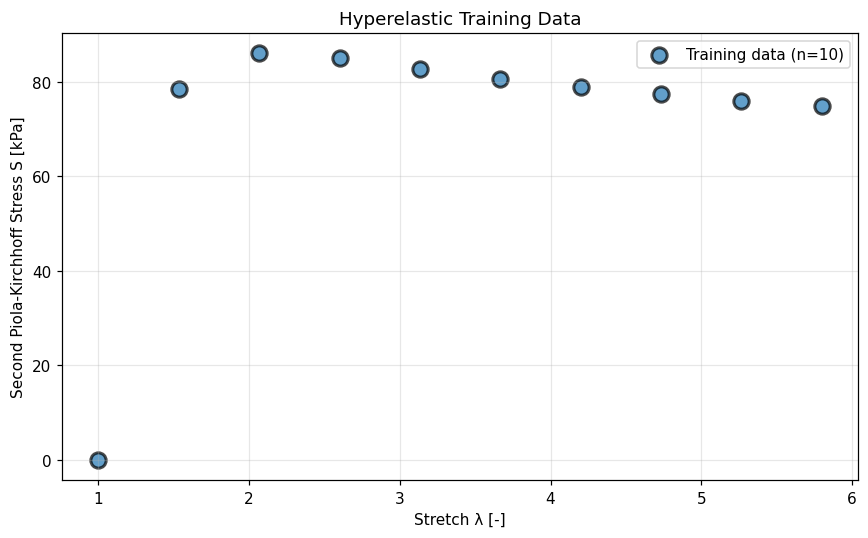

Training range: λ ∈ [1.00, 5.80]
Stress range: S ∈ [0.0, 86.0] kPa


In [47]:
# Generate hyperelastic training data
C1, C2 = 31.68, 34.70  # Material parameters [kPa]

def compute_S_stress(stretch):
    '''Second Piola-Kirchhoff stress from Mooney-Rivlin model'''
    lam = stretch
    return (2*C1*(lam**2 - 1/lam) + 2*C2*(lam - 1/lam**2)) / lam**2

# Training data: uniform spacing in stretch domain
N_points = 10 if FAST else 15
stretch_train = np.linspace(1.0, 5.8, N_points)  # Reasonable extension range
stress_train = compute_S_stress(stretch_train)

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(stretch_train, stress_train, s=100, alpha=0.7,
           edgecolors='black', linewidth=2, label=f'Training data (n={N_points})')
plt.xlabel('Stretch λ [-]')
plt.ylabel('Second Piola-Kirchhoff Stress S [kPa]')
plt.title('Hyperelastic Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training range: λ ∈ [{stretch_train.min():.2f}, {stretch_train.max():.2f}]")
print(f"Stress range: S ∈ [{stress_train.min():.1f}, {stress_train.max():.1f}] kPa")

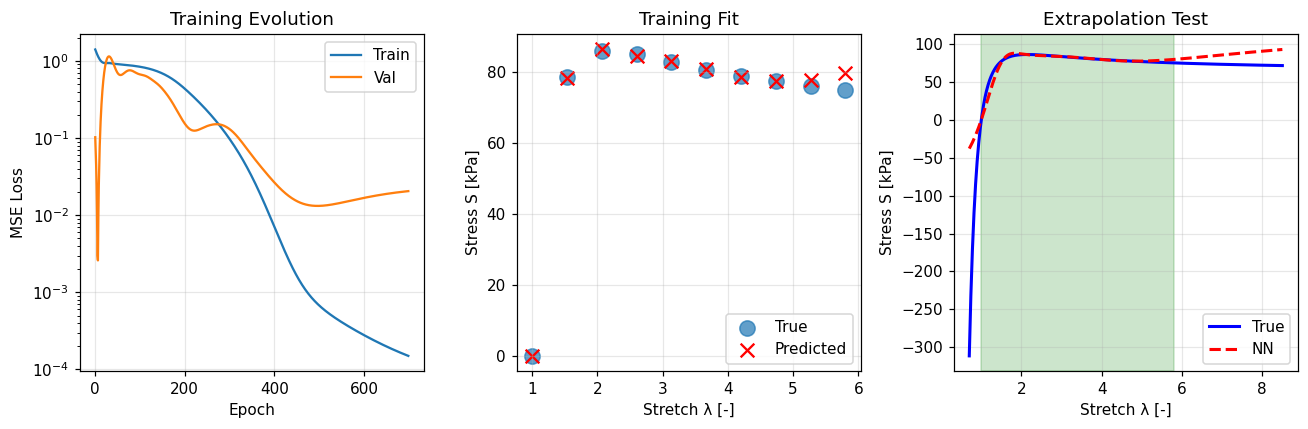


✅ Training MAE: 0.838 kPa
⚠️  Extrapolation fails outside training domain!


In [64]:
def build_mlp(hidden_layers=6, width=32, activation='tanh', l2_reg=None):
    '''Build feedforward network for regression'''
    # Adjust for FAST mode
    n_layers = max(2, hidden_layers // 2) if FAST else hidden_layers
    neurons = max(16, width // 2) if FAST else width

    model = keras.Sequential(name='hyperelastic_mlp')
    model.add(layers.Input(shape=(1,)))

    for i in range(n_layers):
        model.add(layers.Dense(
            neurons,
            activation=activation,
            kernel_regularizer=regularizers.l2(l2_reg) if l2_reg else None,
            name=f'hidden_{i+1}'
        ))

    model.add(layers.Dense(1, name='output'))

    return model

# Build and train
model_clean = build_mlp()

# Normalize data
mean_stretch = stretch_train.mean()
std_stretch = stretch_train.std()
mean_stress = stress_train.mean()
std_stress = stress_train.std()

X_norm = (stretch_train - mean_stretch) / std_stretch
y_norm = (stress_train - mean_stress) / std_stress

# Compile and train
model_clean.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='mse'
)

history = model_clean.fit(
    X_norm.reshape(-1, 1),
    y_norm.reshape(-1, 1),
    epochs=700 if FAST else 1000,
    verbose=0,
    validation_split=0.2
)

# Evaluate
y_pred = model_clean.predict(X_norm.reshape(-1, 1), verbose=0)
y_pred = y_pred.flatten() * std_stress + mean_stress

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.semilogy(history.history['loss'], label='Train')
plt.semilogy(history.history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(stretch_train, stress_train, s=100, alpha=0.7, label='True')
plt.scatter(stretch_train, y_pred, s=80, marker='x', color='red', label='Predicted')
plt.xlabel('Stretch λ [-]')
plt.ylabel('Stress S [kPa]')
plt.title('Training Fit')
plt.legend()
plt.grid(True, alpha=0.3)

# Test extrapolation
stretch_test = np.linspace(0.7, 8.5, 200)
X_test_norm = (stretch_test - mean_stretch) / std_stretch
y_test_pred = model_clean.predict(X_test_norm.reshape(-1, 1), verbose=0)
y_test_pred = y_test_pred.flatten() * std_stress + mean_stress
y_test_true = compute_S_stress(stretch_test)

plt.subplot(1, 3, 3)
plt.plot(stretch_test, y_test_true, 'b-', label='True', linewidth=2)
plt.plot(stretch_test, y_test_pred, 'r--', label='NN', linewidth=2)
plt.axvspan(stretch_train.min(), stretch_train.max(), alpha=0.2, color='green')
plt.xlabel('Stretch λ [-]')
plt.ylabel('Stress S [kPa]')
plt.title('Extrapolation Test')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mae_train = np.mean(np.abs(y_pred - stress_train))
print(f"\n✅ Training MAE: {mae_train:.3f} kPa")
print(f"⚠️  Extrapolation fails outside training domain!")

# Level 2: Handling Noisy Measurements with Regularization

## Why This Matters

**Real-world problem**: Real experimental data contains measurement noise from sensors, environmental variations, sample inhomogeneity, and operator variability. Typical strain measurements have ±0.5% error, stress measurements ±2-5% error. Without proper handling, models overfit to noise rather than learning underlying physics.

**Traditional limitations**: Classical curve fitting with fixed functional forms is robust to noise but inflexible. Adding more parameters improves fit but increases overfitting risk. There is no systematic way to balance flexibility and robustness.

**Key insight**: Regularization explicitly trades off fit quality against model complexity. L2 regularization (weight decay) penalizes large weights, encouraging smooth functions. This prevents the network from contorting itself to match noise exactly.

**Learning objective**: Master regularization techniques to build robust models from noisy data, understand the bias-variance tradeoff, and learn to tune hyperparameters systematically.

---
## Conceptual Foundation

**Mathematical foundation**: The regularized objective becomes:

$$\mathcal{L}_{reg} = \frac{1}{N}\sum_{i=1}^{N}(y_i - f_\theta(x_i))^2 + \lambda\sum_{j}\theta_j^2$$

where $\lambda$ is the regularization strength [dimensionless]. Larger $\lambda$ → smoother function but worse fit.

**Regularization types**:
- **L2 (Ridge)**: Penalizes $\sum \theta^2$ → encourages small, distributed weights → smoother functions
- **L1 (Lasso)**: Penalizes $\sum |\theta|$ → encourages sparse weights → feature selection
- **Elastic Net**: Combines L1 + L2

**Engineering context**:
- Noise level in materials testing: typically 2-10% of signal
- Trade-off: Perfect fit to noisy data vs smooth underlying function
- Validation strategy: Hold out test data never seen during training

---
## Our Learning Strategy

**Progressive approach**:
1. Add controlled noise to training data
2. Train without regularization → observe overfitting
3. Add L2 regularization → find optimal strength
4. Compare interpolation quality between models
5. Validate on noise-free ground truth

**Key experiments**:
- How does noise level affect required regularization?
- Can we recover smooth underlying function from noisy measurements?
- What validation strategy prevents overfitting?

**Success criteria**:
- Model smoothly interpolates despite noise
- Better performance on validation data than training data
- Physical plausibility maintained

---
## Before We Code: Prediction Exercise

- How will noise affect the training loss minimum?
- Will the model from Level 1 overfit if we just add noise to data?
- How much regularization is "enough"—how would you determine this systematically?
- What would you see in plots if the model is underfitting vs overfitting?

### Experiment 1: No Regularization (Overfitting Demonstration)

**Prediction before running**: What will happen if we train the same large network on noisy data without regularization?

### Observation: Overfitting Signature

**What you should see:**
- Wiggly, oscillating predictions between data points
- Model passes exactly through noisy measurements
- Worse performance on smooth true function than necessary

**Physical interpretation**: The network has enough capacity to memorize the noise. It found a high-frequency function that matches training points but does not represent underlying physics.

**Engineering insight**: More capacity is not always better. Flexible models need constraints.

### Experiment 2: L2 Regularization (Proper Approach)

### Critical Lessons: Regularization and Generalization

**Key observations:**
1. **Smoother predictions**: Regularized model does not chase noise
2. **Better validation loss**: Penalizing complexity improves generalization
3. **Physical plausibility**: Smooth stress-stretch curves are more realistic

**Engineering decision framework:**

| Observation | Interpretation | Action |
|-------------|----------------|--------|
| Training loss ≪ validation loss | Overfitting | Increase regularization or reduce capacity |
| Both losses high | Underfitting | Decrease regularization or add capacity |
| Oscillating predictions | Overfitting | Add regularization or early stopping |
| Smooth but biased | Underfitting | Reduce regularization |

**Practical workflow:**
1. Start with moderate regularization (1e-3 to 1e-4)
2. Monitor validation loss during training
3. Use early stopping to prevent overfitting
4. Validate on held-out test data
5. Check physical plausibility of predictions

**Transfer question**: How would you systematically search for optimal regularization strength? (Answer: Grid search or random search with cross-validation)

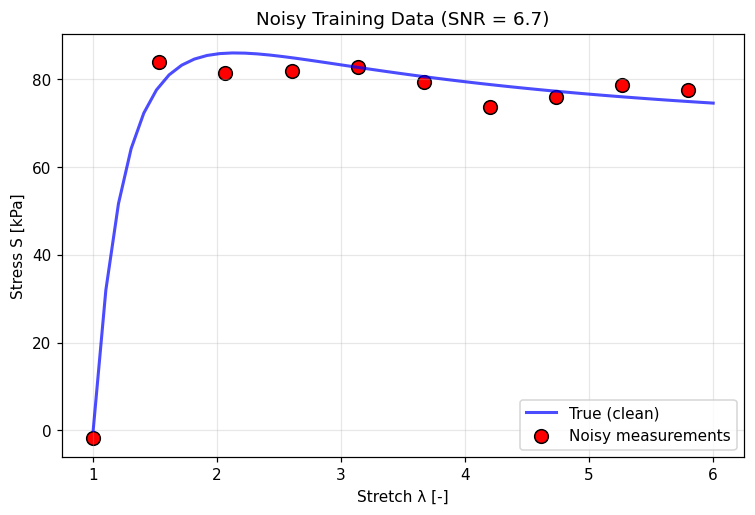

Added noise: ±3.6 kPa


In [65]:
# Add realistic noise to data
noise_level = 0.15  # 15% noise (normalized)
np.random.seed(SEED)
y_noisy_norm = y_norm + np.random.normal(0, noise_level, y_norm.shape)

# Convert back to physical units for plotting
stress_noisy = y_noisy_norm * std_stress + mean_stress

x_true_curve = np.linspace(1,6)
y_true_curve = compute_S_stress(x_true_curve)

plt.figure(figsize=(8, 5))
plt.plot(x_true_curve, y_true_curve, 'b-', linewidth=2, alpha=0.7, label='True (clean)')
plt.scatter(stretch_train, stress_noisy, s=80, color='red',
           edgecolors='black', linewidth=1, label='Noisy measurements')
plt.xlabel('Stretch λ [-]')
plt.ylabel('Stress S [kPa]')
plt.title(f'Noisy Training Data (SNR = {1/noise_level:.1f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Added noise: ±{noise_level * std_stress:.1f} kPa")

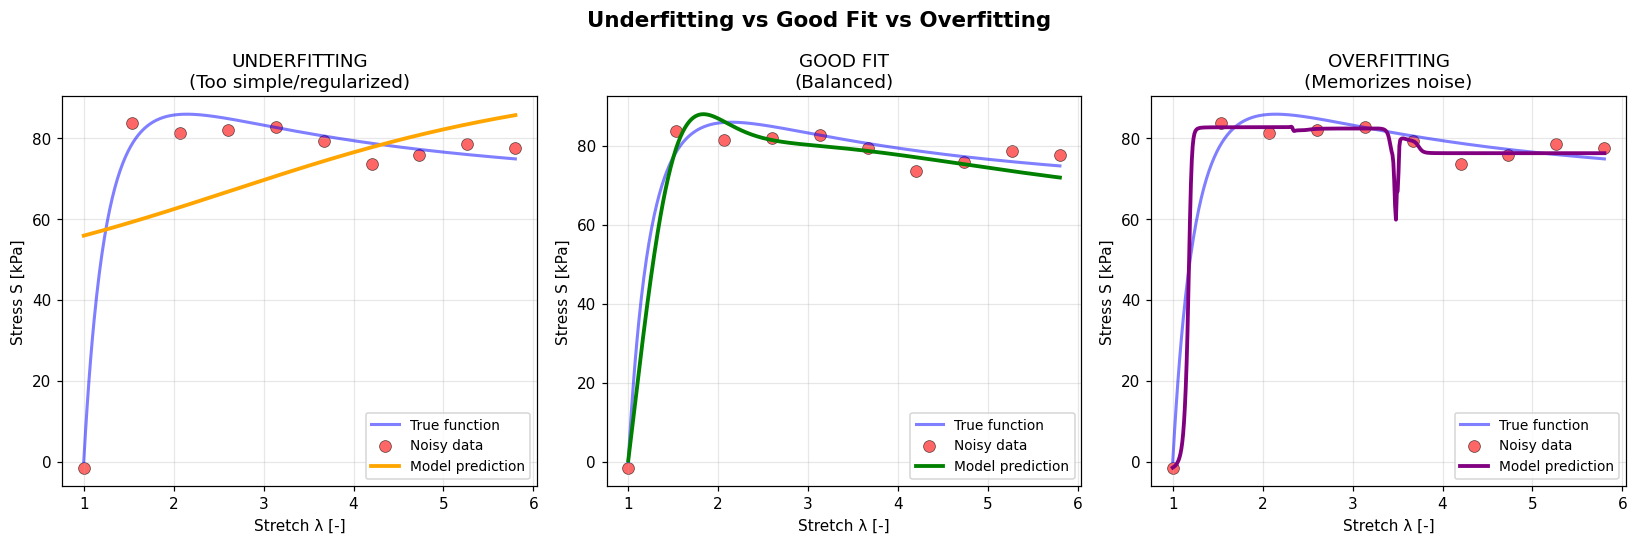


MAE on true function:
  Underfitting: 11.63 kPa (too smooth)
  Good fit:     2.92 kPa (balanced)
  Overfitting:  3.38 kPa (chases noise)


In [50]:
# Model 1: UNDERFITTING (too much regularization)
model_under = build_mlp(hidden_layers=2, width=8, l2_reg=0.1)  # Heavy L2
model_under.compile(optimizer=keras.optimizers.SGD(0.01), loss='mse')
model_under.fit(X_norm.reshape(-1,1), y_noisy_norm.reshape(-1,1),
               epochs=200, verbose=0)

# Model 2: GOOD FIT (balanced)
model_good = build_mlp(hidden_layers=4, width=32, l2_reg=0.01)  # Moderate L2
model_good.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse')
model_good.fit(X_norm.reshape(-1,1), y_noisy_norm.reshape(-1,1),
              epochs=500, verbose=0, validation_split=0.2)

# Model 3: OVERFITTING (complex, no regularization, overtrained)
model_over = build_mlp(hidden_layers=8, width=64, l2_reg=None)  # No L2
model_over.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse')
# Train longer without early stopping to force overfitting
model_over.fit(X_norm.reshape(-1,1), y_noisy_norm.reshape(-1,1),
              epochs=2000, verbose=0, batch_size=2)  # Small batch = more noise

# Predictions on dense grid
stretch_dense = np.linspace(stretch_train.min(), stretch_train.max(), 500)
X_dense_norm = (stretch_dense - mean_stretch) / std_stretch
stress_true_dense = compute_S_stress(stretch_dense)

pred_under = model_under.predict(X_dense_norm.reshape(-1,1), verbose=0).flatten()
pred_under = pred_under * std_stress + mean_stress

pred_good = model_good.predict(X_dense_norm.reshape(-1,1), verbose=0).flatten()
pred_good = pred_good * std_stress + mean_stress

pred_over = model_over.predict(X_dense_norm.reshape(-1,1), verbose=0).flatten()
pred_over = pred_over * std_stress + mean_stress

# Visualization: Three panels showing the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, pred, title, color in zip(
    axes,
    [pred_under, pred_good, pred_over],
    ['UNDERFITTING\n(Too simple/regularized)',
     'GOOD FIT\n(Balanced)',
     'OVERFITTING\n(Memorizes noise)'],
    ['orange', 'green', 'purple']
):
    ax.plot(stretch_dense, stress_true_dense, 'b-', linewidth=2,
           alpha=0.5, label='True function')
    ax.scatter(stretch_train, stress_noisy, s=60, color='red',
              alpha=0.6, edgecolors='black', linewidth=0.5, label='Noisy data')
    ax.plot(stretch_dense, pred, color=color, linewidth=2.5,
           label='Model prediction')

    ax.set_xlabel('Stretch λ [-]')
    ax.set_ylabel('Stress S [kPa]')
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Underfitting vs Good Fit vs Overfitting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate errors
mae_under = np.mean(np.abs(pred_under - stress_true_dense))
mae_good = np.mean(np.abs(pred_good - stress_true_dense))
mae_over = np.mean(np.abs(pred_over - stress_true_dense))

print(f"\nMAE on true function:")
print(f"  Underfitting: {mae_under:.2f} kPa (too smooth)")
print(f"  Good fit:     {mae_good:.2f} kPa (balanced)")
print(f"  Overfitting:  {mae_over:.2f} kPa (chases noise)")

# Level 3: History-Dependent Materials and Recurrent Networks

## Why This Matters

**Real-world problem**: Many engineering materials exhibit history dependence—stress depends not just on current strain but on loading history. Examples:
- **Viscoelastic polymers**: Creep under constant load, stress relaxation
- **Biological tissues**: Rate-dependent stiffening (tendons, blood vessels)
- **Metal plasticity**: Strain hardening depends on deformation path

Standard feedforward networks cannot capture this behavior because they lack memory.

**Traditional limitations**: Phenomenological models (Maxwell, Kelvin-Voigt, Prony series) require choosing specific mechanical analogs. Generalizing to complex loading histories requires many parameters.

**Key insight**: Recurrent Neural Networks (RNNs) maintain a hidden state that acts as memory. At each time step:

$$h_t = \tanh(W_x x_t + W_h h_{t-1} + b)$$

$$y_t = W_y h_t + c$$

The hidden state $h_t$ summarizes relevant history, enabling the network to learn history-dependent relationships from data.

**Learning objective**: Understand when history matters, why feedforward networks fail, how RNNs work, and how to properly structure sequential data for training.

---
## Conceptual Foundation

**Physical model**: Maxwell power-law viscoelastic solid:

$$\dot{\sigma} = E \dot{\lambda} - \frac{\sigma}{\nu_0}\left|\frac{\sigma}{\sigma_0}\right|^{m-1}$$

where:
- $E$ = elastic modulus [kPa]
- $\nu_0$ = viscosity [kPa·s]
- $\sigma_0$ = reference stress [kPa]
- $m$ = power-law exponent [-]

This differential equation means stress depends on entire loading history, not just current strain.

**RNN architecture**:
- **Hidden state**: Vector $h_t \in \mathbb{R}^d$ that summarizes history
- **State dimensionality** $d$: Critical hyperparameter (larger = more memory capacity)
- **Advantages**: Handles variable-length sequences, fewer parameters than feedforward
- **Challenges**: Vanishing/exploding gradients, harder to train

**Engineering context**:
- Loading rate effects: Fast loading → stiffer response
- Hysteresis loops: Different loading/unloading paths
- Time-dependent recovery after load removal

---
## Our Learning Strategy

**Progressive demonstration**:
1. Generate viscoelastic data with rate dependence
2. Attempt to fit with feedforward network → failure
3. Introduce RNN architecture with hidden state
4. Train on sequence data with proper formatting
5. Validate on different loading rates

**Key experiments**:
- Can feedforward network learn rate-dependent behavior?
- How does hidden state size affect learning?
- Does trained RNN generalize to new loading rates?

**Success criteria**:
- Clear failure of feedforward approach
- RNN captures training sequence accurately
- Physical plausibility on validation loading paths
- Understanding of sequence data formatting

---
## Before We Code: Prediction Exercise

- Why will the hyperelastic network fail on viscoelastic data?
- What information must the hidden state store?
- How should we structure input data (single points vs sequences)?
- What would successful learning look like for a history-dependent material?

### Data Generation: Viscoelastic Model

Generated reference viscoelastic curves:
  Curve 1: rate = 1.0 /s, 2992 points, duration = 2.99 s
  Curve 2: rate = 3.0 /s, 2992 points, duration = 1.00 s


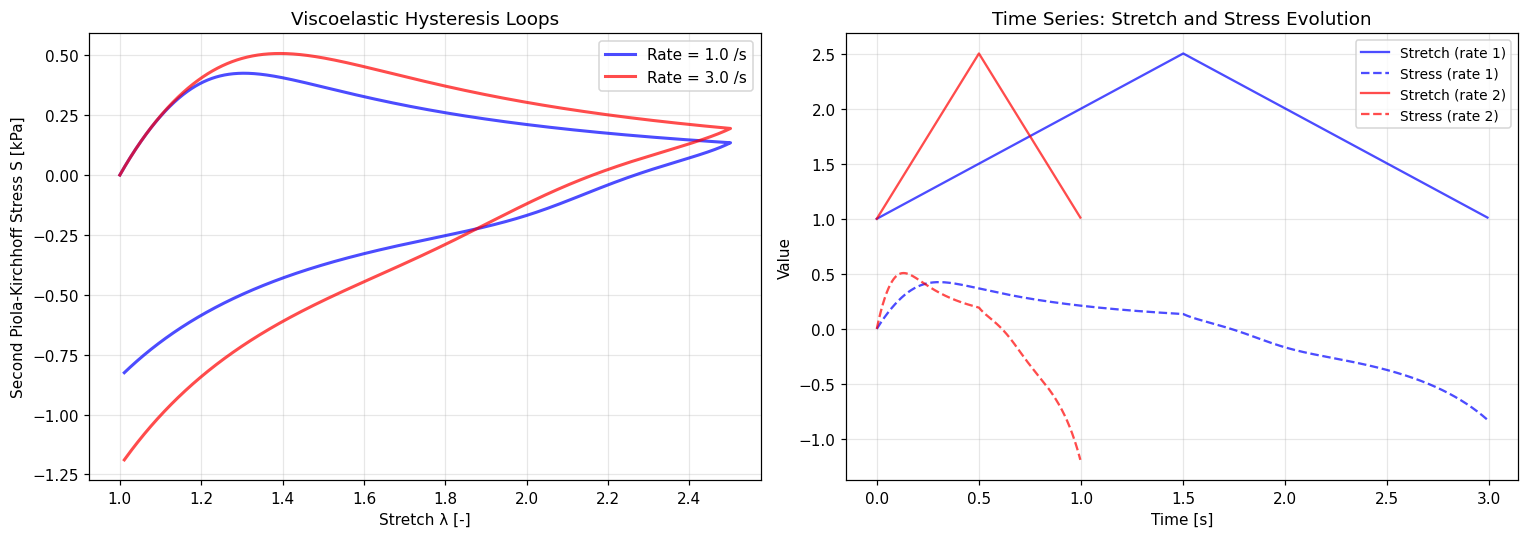


📊 Key observations:
  1. Higher rate → stiffer response (higher peak stress)
  2. Hysteresis loops show energy dissipation
  3. Different loading/unloading paths → history dependence


In [51]:
# Maxwell power-law model parameters
E_visco = 3.0      # Elastic modulus [kPa]
nu_0 = 2e-1        # Viscosity coefficient [kPa·s]
sigma_0 = 1.0      # Reference stress [kPa]
m = 3              # Power-law exponent [-]

def sigma_dot(sigma, strain_rate):
    """
    Compute stress rate from Maxwell power-law model.

    Parameters:
        sigma: Current Cauchy stress [kPa]
        strain_rate: Current strain rate [1/s]

    Returns:
        dsigma_dt: Stress rate [kPa/s]
    """
    elastic_term = E_visco * strain_rate

    if abs(sigma) < 1e-10:
        viscous_term = 0.0
    else:
        viscous_term = (sigma / nu_0) * abs(sigma / sigma_0)**(m - 1)

    return elastic_term - viscous_term

# Generate two loading paths with different rates
def generate_visco_path(rate, dt_factor=1.0):
    """Generate viscoelastic loading/unloading path."""
    dt = 1e-3 / rate * dt_factor

    stretch = 1.0
    stress = 0.0

    stretches = []
    stresses = []
    times = []
    rates = []

    t = 0.0

    # Loading phase: stretch from 1.0 to 2.5
    while stretch < 2.5:
        stretches.append(stretch)
        stresses.append(stress / stretch**2)  # Convert to S
        times.append(t)
        rates.append(rate)

        dsigma_dt = sigma_dot(stress, rate)
        stretch += dt * rate
        stress += dt * dsigma_dt
        t += dt

    # Unloading phase: return to 1.0
    while stretch > 1.01:
        stretches.append(stretch)
        stresses.append(stress / stretch**2)
        times.append(t)
        rates.append(-rate)

        dsigma_dt = sigma_dot(stress, -rate)
        stretch -= dt * rate
        stress += dt * dsigma_dt
        t += dt

    return np.array(stretches), np.array(stresses), np.array(times), np.array(rates)

# Generate two reference curves with constant rates
rate1 = 1.0  # [1/s]
rate2 = 3.0  # [1/s]

stretch1, stress1, time1, rates1 = generate_visco_path(rate1)
stretch2, stress2, time2, rates2 = generate_visco_path(rate2)

print(f"Generated reference viscoelastic curves:")
print(f"  Curve 1: rate = {rate1} /s, {len(stretch1)} points, duration = {time1[-1]:.2f} s")
print(f"  Curve 2: rate = {rate2} /s, {len(stretch2)} points, duration = {time2[-1]:.2f} s")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stress-stretch (hysteresis loops)
ax1.plot(stretch1, stress1, 'b-', linewidth=2, label=f'Rate = {rate1} /s', alpha=0.7)
ax1.plot(stretch2, stress2, 'r-', linewidth=2, label=f'Rate = {rate2} /s', alpha=0.7)
ax1.set_xlabel('Stretch λ [-]')
ax1.set_ylabel('Second Piola-Kirchhoff Stress S [kPa]')
ax1.set_title('Viscoelastic Hysteresis Loops')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time series
ax2.plot(time1, stretch1, 'b-', linewidth=1.5, label='Stretch (rate 1)', alpha=0.7)
ax2.plot(time1, stress1, 'b--', linewidth=1.5, label='Stress (rate 1)', alpha=0.7)
ax2.plot(time2, stretch2, 'r-', linewidth=1.5, label='Stretch (rate 2)', alpha=0.7)
ax2.plot(time2, stress2, 'r--', linewidth=1.5, label='Stress (rate 2)', alpha=0.7)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Value')
ax2.set_title('Time Series: Stretch and Stress Evolution')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Key observations:")
print(f"  1. Higher rate → stiffer response (higher peak stress)")
print(f"  2. Hysteresis loops show energy dissipation")
print(f"  3. Different loading/unloading paths → history dependence")

### Critical Observation: Rate Dependence

**Physical interpretation**:
- At slow rates, viscous dissipation has time to relax → softer response
- At fast rates, elastic response dominates → stiffer response
- Area inside hysteresis loop = energy dissipated per cycle

**Why this matters**: Loading rate drastically affects material response. Any model must capture this rate dependence to be useful for engineering design.

### Failure of Feedforward Networks (Demonstration)

Training sequence: 32 time steps
Subsampled to 100 points for FAST mode


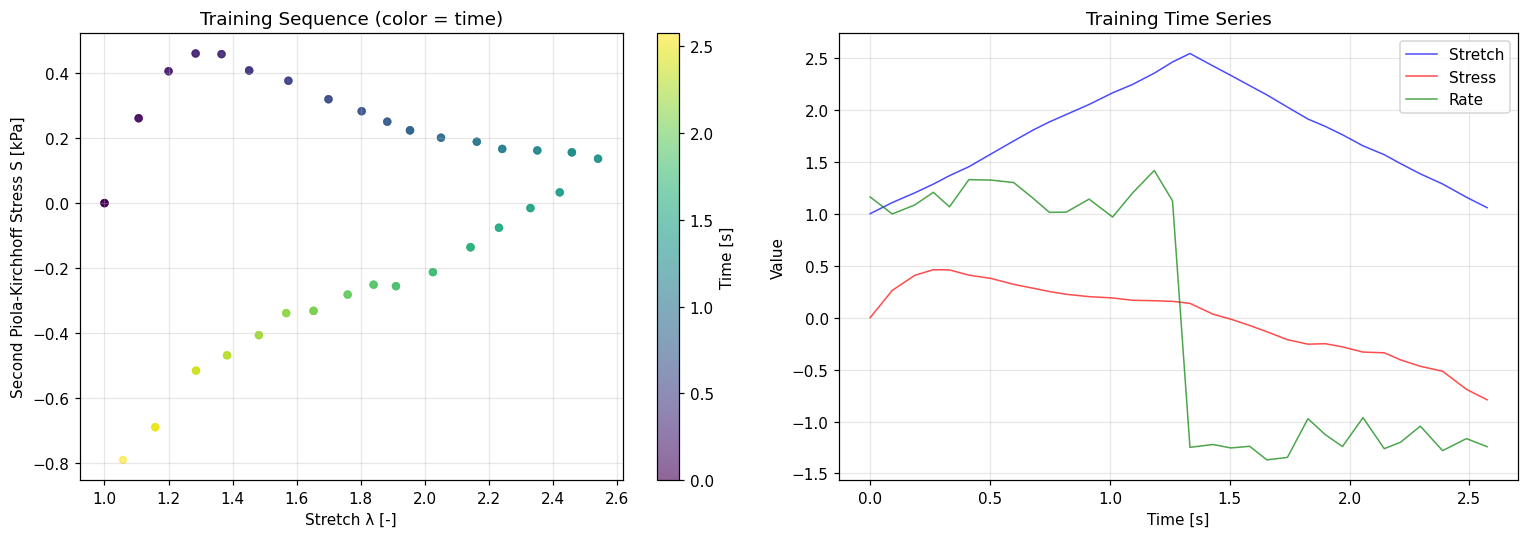

In [52]:
# Generate training data: variable-rate sequence
np.random.seed(SEED)

stretch_seq = []
stress_seq = []
rate_seq = []
time_seq = []

stretch = 1.0
stress = 0.0
t = 0.0

rate_mean = 1.2  # Base rate [1/s]
dt_mean = 1e-1 / rate_mean

# Create varied loading history
while stretch < 2.5:
    stretch_seq.append(stretch)
    stress_seq.append(stress / stretch**2)

    dt = dt_mean * np.random.uniform(0.8, 1.2)
    rate = rate_mean * np.random.uniform(0.8, 1.2)

    rate_seq.append(rate)
    time_seq.append(t)

    dsigma_dt = sigma_dot(stress, rate)
    stretch += dt * rate
    stress += dt * dsigma_dt
    t += dt

# Unloading
while stretch > 1.01:
    stretch_seq.append(stretch)
    stress_seq.append(stress / stretch**2)

    dt = dt_mean * np.random.uniform(0.8, 1.2)
    rate = -rate_mean * np.random.uniform(0.8, 1.2)

    rate_seq.append(rate)
    time_seq.append(t)

    dsigma_dt = sigma_dot(stress, rate)
    stretch += dt * rate
    stress += dt * dsigma_dt
    t += dt

stretch_seq = np.array(stretch_seq)
stress_seq = np.array(stress_seq)
rate_seq = np.array(rate_seq)
time_seq = np.array(time_seq)

print(f"Training sequence: {len(stretch_seq)} time steps")

# Subsample for manageable training (if needed)
if FAST:
    indices = np.linspace(0, len(stretch_seq)-1, 100, dtype=int)
    stretch_seq = stretch_seq[indices]
    stress_seq = stress_seq[indices]
    rate_seq = rate_seq[indices]
    time_seq = time_seq[indices]
    print(f"Subsampled to {len(stretch_seq)} points for FAST mode")

# Visualize training data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(stretch_seq, stress_seq, s=20, alpha=0.6, c=time_seq, cmap='viridis')
ax1.set_xlabel('Stretch λ [-]')
ax1.set_ylabel('Second Piola-Kirchhoff Stress S [kPa]')
ax1.set_title('Training Sequence (color = time)')
ax1.grid(True, alpha=0.3)
cbar = plt.colorbar(ax1.collections[0], ax=ax1)
cbar.set_label('Time [s]')

ax2.plot(time_seq, stretch_seq, 'b-', linewidth=1, label='Stretch', alpha=0.7)
ax2.plot(time_seq, stress_seq, 'r-', linewidth=1, label='Stress', alpha=0.7)
ax2.plot(time_seq, rate_seq, 'g-', linewidth=1, label='Rate', alpha=0.7)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Value')
ax2.set_title('Training Time Series')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Prediction Exercise: Will Feedforward Network Work?

**Stop and predict before running:**

1. The feedforward network can only see current stretch (input). Can it predict stress without knowing loading history?
2. For the same stretch value, stress differs depending on whether we are loading or unloading. How could a feedforward network handle this?
3. What will the scatter plot of predictions vs. true stress look like?

**Write your prediction, then run the next cell.**

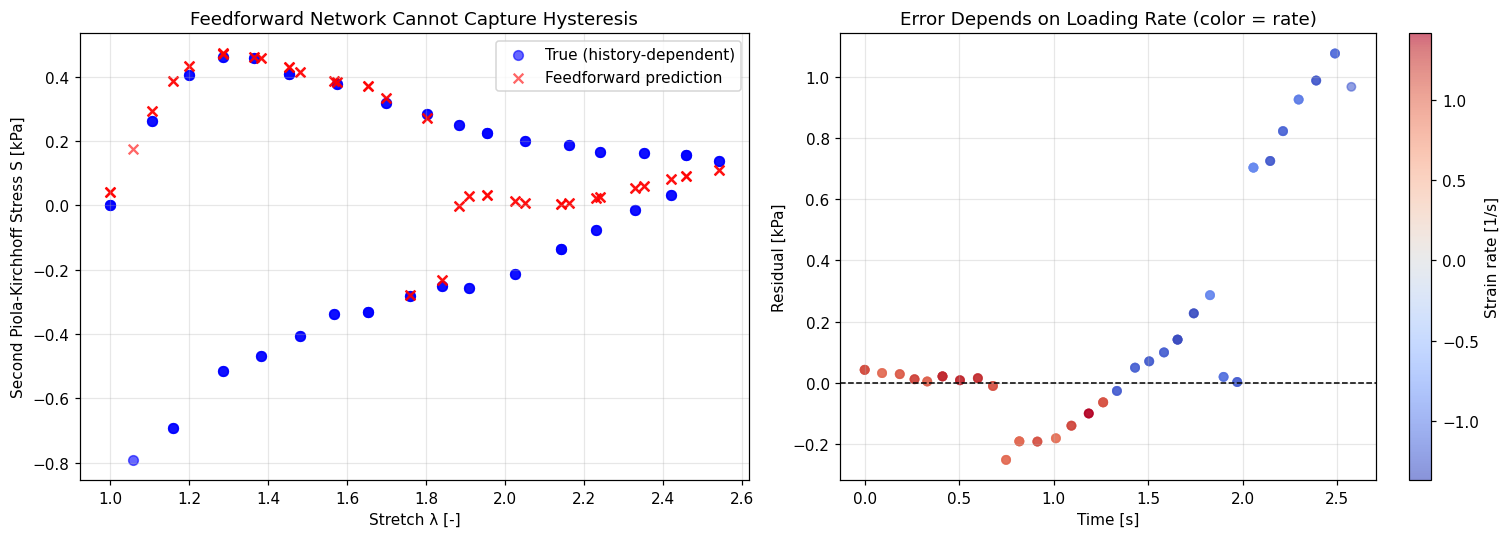


Feedforward network performance:
  MAE: 0.245 kPa
  ❌ Network produces single-valued function—cannot capture hysteresis!
  ❌ Same stretch → same predicted stress, regardless of history


In [53]:
# Attempt to train feedforward network on viscoelastic data
# (This should fail—demonstrating the need for history)

# Normalize data
mean_stretch_visco = stretch_seq.mean()
std_stretch_visco = stretch_seq.std()
mean_stress_visco = stress_seq.mean()
std_stress_visco = stress_seq.std()

X_visco_norm = (stretch_seq - mean_stretch_visco) / std_stretch_visco
y_visco_norm = (stress_seq - mean_stress_visco) / std_stress_visco


model_ff_visco = build_mlp(
    hidden_layers=6,
    width=32,
    activation='tanh',
    l2_reg=None
)

# Compile
model_ff_visco.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss='mse'
)

# Train
history_ff_visco = model_ff_visco.fit(
    X_visco_norm.reshape(-1, 1),
    y_visco_norm.reshape(-1, 1),
    epochs=500 if FAST else 1000,
    verbose=0,
    validation_split=0.2
)

# Predictions
y_pred_ff_visco = model_ff_visco.predict(X_visco_norm.reshape(-1, 1), verbose=0)
y_pred_ff_visco = y_pred_ff_visco.flatten() * std_stress_visco + mean_stress_visco

# Visualization: The failure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Predictions vs training data
ax1.scatter(stretch_seq, stress_seq, s=40, alpha=0.6,
           label='True (history-dependent)', c='blue')
ax1.scatter(stretch_seq, y_pred_ff_visco, s=40, alpha=0.6, marker='x',
           label='Feedforward prediction', c='red')
ax1.set_xlabel('Stretch λ [-]')
ax1.set_ylabel('Second Piola-Kirchhoff Stress S [kPa]')
ax1.set_title('Feedforward Network Cannot Capture Hysteresis')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals vs time
residuals_ff = y_pred_ff_visco - stress_seq
ax2.scatter(time_seq, residuals_ff, s=30, alpha=0.6, c=rate_seq, cmap='coolwarm')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Residual [kPa]')
ax2.set_title('Error Depends on Loading Rate (color = rate)')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('Strain rate [1/s]')

plt.tight_layout()
plt.show()

mae_ff_visco = np.mean(np.abs(residuals_ff))
print(f"\nFeedforward network performance:")
print(f"  MAE: {mae_ff_visco:.3f} kPa")
print(f"  ❌ Network produces single-valued function—cannot capture hysteresis!")
print(f"  ❌ Same stretch → same predicted stress, regardless of history")

### Analysis: Why Feedforward Networks Fail for History-Dependent Materials

**What you should observe:**
- Network predicts a single stress value for each stretch
- Cannot capture hysteresis loop (different stress for same stretch during loading vs unloading)
- Systematic errors correlated with loading rate

**Mathematical explanation**:
Feedforward network learns $f: \lambda \to S$, but true relationship is:

$$S(t) = F[\lambda(\tau), \dot{\lambda}(\tau)]_{\tau \leq t}$$

where $F$ is a functional (depends on entire history, not just current value).

**Engineering implication**:
> For history-dependent materials, we must either:
> 1. Include explicit history variables as inputs (stress history, time derivatives)
> 2. Use recurrent architectures with memory (RNN, LSTM, GRU)

We will now implement approach #2.

### Recurrent Neural Network Architecture

In [54]:
def build_simple_rnn(hidden_size=8, num_layers=2):
    """
    Build simple RNN for viscoelastic modeling.

    Input format: (batch, time_steps, features=3)
        features = [stretch, strain_rate, dt]

    Output: (batch, time_steps, 1)
        predicted stress at each time step

    Parameters:
        hidden_size: dimensionality of RNN hidden state
        num_layers: number of stacked RNN layers

    Returns:
        Keras Model
    """
    # Adjust for FAST mode
    h_size = hidden_size if not FAST else max(4, hidden_size // 2)
    n_layers = num_layers if not FAST else max(1, num_layers // 2)

    inp = layers.Input(shape=(None, 3), name='sequence_input')  # Variable length

    x = inp
    for i in range(n_layers):
        return_seq = (i < n_layers - 1) or True  # Always return sequences for output
        x = layers.SimpleRNN(
            h_size,
            activation='tanh',
            return_sequences=return_seq,
            name=f'rnn_layer_{i+1}'
        )(x)

    # Output layer
    out = layers.Dense(1, activation='linear', name='stress_output')(x)

    model = keras.Model(inp, out, name='viscoelastic_rnn')

    print(f"\n📊 RNN architecture (FAST={'ON' if FAST else 'OFF'}):")
    print(f"   Hidden state size: {h_size}")
    print(f"   Number of RNN layers: {n_layers}")
    print(f"   Input: (batch, timesteps, 3) [stretch, rate, dt]")
    print(f"   Output: (batch, timesteps, 1) [stress]")

    return model

# Build RNN
hidden_state_size = 8 if not FAST else 4
rnn_layers = 3 if not FAST else 2

model_rnn_visco = build_simple_rnn(
    hidden_size=hidden_state_size,
    num_layers=rnn_layers
)

model_rnn_visco.summary()


📊 RNN architecture (FAST=ON):
   Hidden state size: 4
   Number of RNN layers: 1
   Input: (batch, timesteps, 3) [stretch, rate, dt]
   Output: (batch, timesteps, 1) [stress]


Model: "viscoelastic_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, None, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_1 (SimpleRNN)         │ (None, None, 4)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stress_output (Dense)           │ (None, None, 1)        │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

### Data Formatting for RNNs

**Critical concept**: RNNs process sequences. We must format data as:

$$X = [x_1, x_2, ..., x_T]$$

where each $x_t = [\lambda_t, \dot{\lambda}_t, \Delta t]$ contains current state and rate information.

The network processes this sequentially:
$$h_t = f(x_t, h_{t-1})$$

maintaining a hidden state that summarizes history.

RNN input shape: (1, 100, 3)
RNN output shape: (1, 100, 1)
Sequence length: 100 time steps

🏋️ Training RNN on viscoelastic sequence...


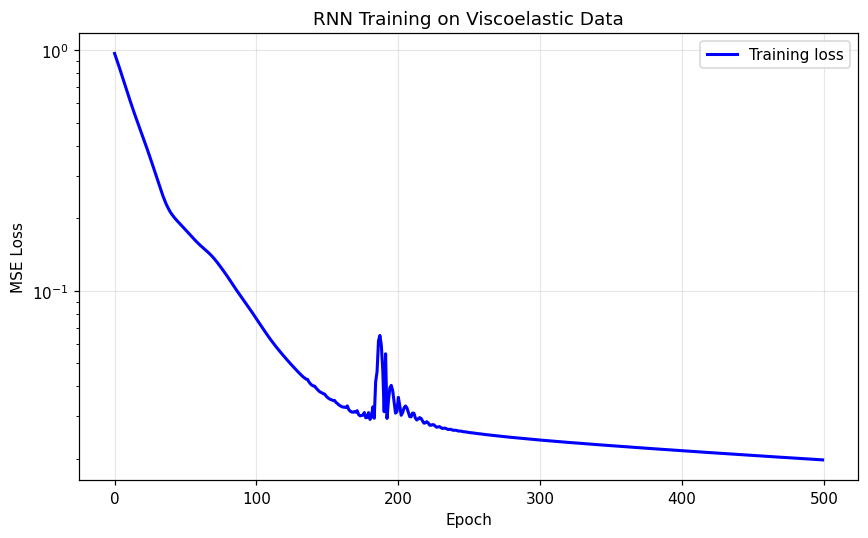


Final loss: 1.98e-02


In [55]:
# Format data for RNN training
# Need: [stretch, strain_rate, dt] at each time step

# Compute dt from time sequence
dt_seq = np.diff(time_seq, prepend=time_seq[0])

# Normalize inputs
mean_rate = rate_seq.mean()
std_rate = rate_seq.std()
mean_dt = dt_seq.mean()
std_dt = dt_seq.std()

stretch_norm = (stretch_seq - mean_stretch_visco) / std_stretch_visco
rate_norm = (rate_seq - mean_rate) / std_rate
dt_norm = (dt_seq - mean_dt) / std_dt
stress_norm = (stress_seq - mean_stress_visco) / std_stress_visco

# Stack features
X_rnn = np.stack([stretch_norm, rate_norm, dt_norm], axis=1)  # (T, 3)
y_rnn = stress_norm.reshape(-1, 1)  # (T, 1)

# Add batch dimension
X_rnn = X_rnn[np.newaxis, :, :]  # (1, T, 3)
y_rnn = y_rnn[np.newaxis, :, :]  # (1, T, 1)

print(f"RNN input shape: {X_rnn.shape}")
print(f"RNN output shape: {y_rnn.shape}")
print(f"Sequence length: {X_rnn.shape[1]} time steps")

# Train RNN
opt = keras.optimizers.Adam(learning_rate=1e-2 if not FAST else 5e-3)
model_rnn_visco.compile(optimizer=opt, loss="mse", metrics=["mae"])

# Callbacks
es_rnn = callbacks.EarlyStopping(patience=200 if not FAST else 50,
                                 restore_best_weights=True, monitor="loss")
ckpt_rnn = callbacks.ModelCheckpoint("model_best_rnn_visco.keras",
                                     save_best_only=True, monitor="loss")

print("\n🏋️ Training RNN on viscoelastic sequence...")

history_rnn_visco = model_rnn_visco.fit(
    X_rnn, y_rnn,
    epochs=(2000 if not FAST else 500),
    batch_size=1,
    verbose=0,
    callbacks=[es_rnn, ckpt_rnn]
, shuffle=False)

# Plot training
fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogy(history_rnn_visco.history['loss'], 'b-', linewidth=2, label='Training loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('RNN Training on Viscoelastic Data')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal loss: {history_rnn_visco.history['loss'][-1]:.2e}")

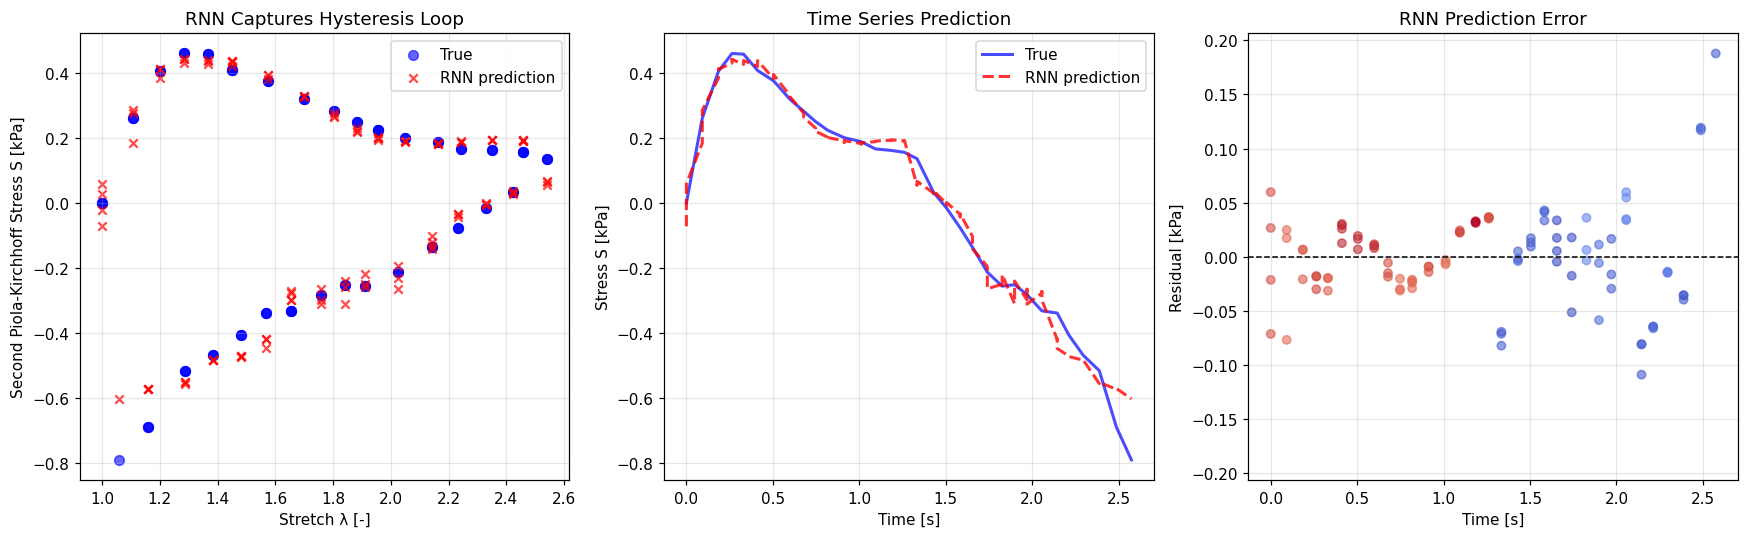


RNN performance on training sequence:
  MAE: 0.033 kPa
  ✅ Successfully captures hysteresis and rate dependence!


In [56]:
# Evaluate RNN predictions on training sequence
y_pred_rnn = model_rnn_visco.predict(X_rnn, verbose=0)
y_pred_rnn_physical = y_pred_rnn[0, :, 0] * std_stress_visco + mean_stress_visco

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Predictions vs true
ax = axes[0]
ax.scatter(stretch_seq, stress_seq, s=40, alpha=0.6, c='blue', label='True')
ax.scatter(stretch_seq, y_pred_rnn_physical, s=30, alpha=0.7, marker='x',
          c='red', label='RNN prediction')
ax.set_xlabel('Stretch λ [-]')
ax.set_ylabel('Second Piola-Kirchhoff Stress S [kPa]')
ax.set_title('RNN Captures Hysteresis Loop')
ax.legend()
ax.grid(True, alpha=0.3)

# Time series
ax = axes[1]
ax.plot(time_seq, stress_seq, 'b-', linewidth=2, label='True', alpha=0.7)
ax.plot(time_seq, y_pred_rnn_physical, 'r--', linewidth=2,
       label='RNN prediction', alpha=0.8)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Stress S [kPa]')
ax.set_title('Time Series Prediction')
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals
ax = axes[2]
residuals_rnn = y_pred_rnn_physical - stress_seq
ax.scatter(time_seq, residuals_rnn, s=30, alpha=0.6, c=rate_norm, cmap='coolwarm')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residual [kPa]')
ax.set_title('RNN Prediction Error')
ax.grid(True, alpha=0.3)

max_res = max(abs(residuals_rnn.min()), abs(residuals_rnn.max()))
ax.set_ylim(-max_res*1.1, max_res*1.1)

plt.tight_layout()
plt.show()

mae_rnn_train = np.mean(np.abs(residuals_rnn))
print(f"\nRNN performance on training sequence:")
print(f"  MAE: {mae_rnn_train:.3f} kPa")
print(f"  ✅ Successfully captures hysteresis and rate dependence!")

Do we think the model is good now?

Answer here:

### Validation: Generalization to New Loading Rates

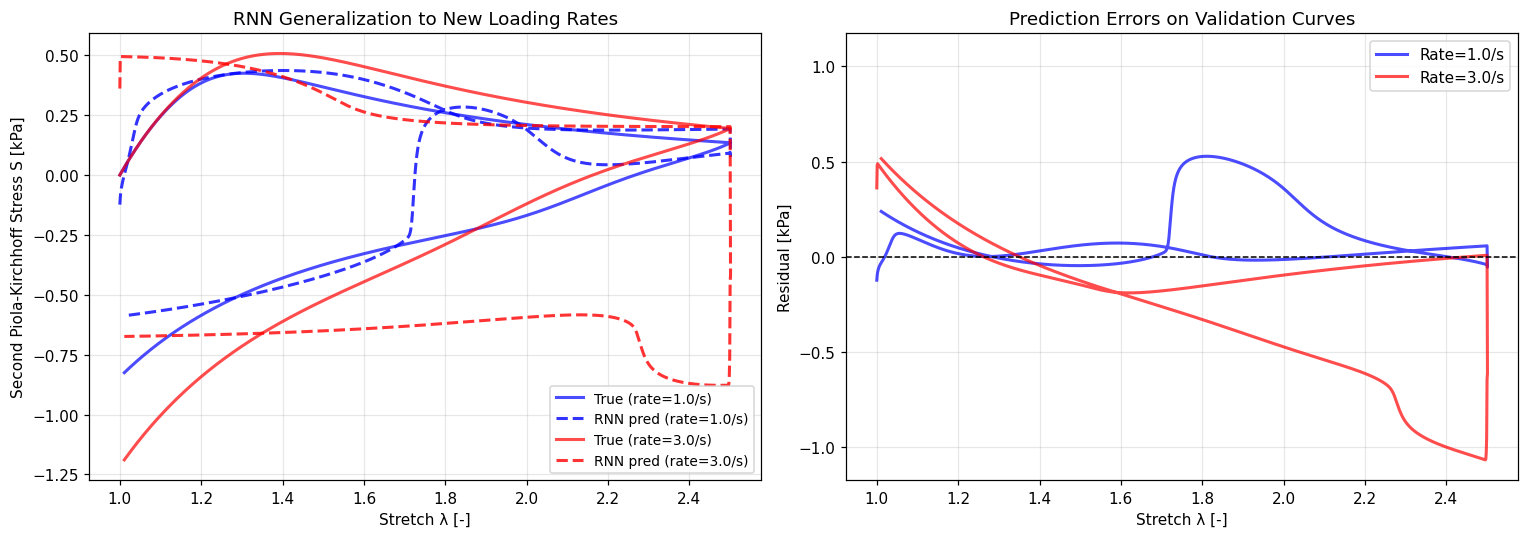


RNN validation performance:
  MAE (rate=1.0/s): 0.091 kPa
  MAE (rate=3.0/s): 0.261 kPa

⚠️ Generalization is limited—model trained on variable rates
   but did not see these specific constant-rate paths


In [57]:
# Test RNN on the constant-rate reference curves
def prepare_rnn_input(stretch_arr, rate_arr, time_arr):
    """Format arrays for RNN input."""
    dt_arr = np.diff(time_arr, prepend=time_arr[0])

    stretch_norm = (stretch_arr - mean_stretch_visco) / std_stretch_visco
    rate_norm_arr = (rate_arr - mean_rate) / std_rate
    dt_norm_arr = (dt_arr - mean_dt) / std_dt

    X = np.stack([stretch_norm, rate_norm_arr, dt_norm_arr], axis=1)
    X = X[np.newaxis, :, :]  # Add batch dimension

    return X

# Prepare inputs for both reference curves
X_test1 = prepare_rnn_input(stretch1, rates1, time1)
X_test2 = prepare_rnn_input(stretch2, rates2, time2)

# Predictions
y_pred1 = model_rnn_visco.predict(X_test1, verbose=0)
y_pred1_physical = y_pred1[0, :, 0] * std_stress_visco + mean_stress_visco

y_pred2 = model_rnn_visco.predict(X_test2, verbose=0)
y_pred2_physical = y_pred2[0, :, 0] * std_stress_visco + mean_stress_visco

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hysteresis loops
ax1.plot(stretch1, stress1, 'b-', linewidth=2, label=f'True (rate={rate1}/s)', alpha=0.7)
ax1.plot(stretch1, y_pred1_physical, 'b--', linewidth=2,
        label=f'RNN pred (rate={rate1}/s)', alpha=0.8)
ax1.plot(stretch2, stress2, 'r-', linewidth=2, label=f'True (rate={rate2}/s)', alpha=0.7)
ax1.plot(stretch2, y_pred2_physical, 'r--', linewidth=2,
        label=f'RNN pred (rate={rate2}/s)', alpha=0.8)
ax1.set_xlabel('Stretch λ [-]')
ax1.set_ylabel('Second Piola-Kirchhoff Stress S [kPa]')
ax1.set_title('RNN Generalization to New Loading Rates')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Residuals
residuals1 = y_pred1_physical - stress1
residuals2 = y_pred2_physical - stress2

ax2.plot(stretch1, residuals1, 'b-', linewidth=2, label=f'Rate={rate1}/s', alpha=0.7)
ax2.plot(stretch2, residuals2, 'r-', linewidth=2, label=f'Rate={rate2}/s', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Stretch λ [-]')
ax2.set_ylabel('Residual [kPa]')
ax2.set_title('Prediction Errors on Validation Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

max_res = max(abs(residuals1).max(), abs(residuals2).max())
ax2.set_ylim(-max_res*1.1, max_res*1.1)

plt.tight_layout()
plt.show()

# Quantitative metrics
mae1 = np.mean(np.abs(residuals1))
mae2 = np.mean(np.abs(residuals2))

print(f"\nRNN validation performance:")
print(f"  MAE (rate={rate1}/s): {mae1:.3f} kPa")
print(f"  MAE (rate={rate2}/s): {mae2:.3f} kPa")
print(f"\n⚠️ Generalization is limited—model trained on variable rates")
print(f"   but did not see these specific constant-rate paths")

### Critical Lessons: RNNs for History-Dependent Materials

**What you should observe:**
1. **Training success**: RNN accurately reproduces training sequence with hysteresis
2. **Partial generalization**: Reasonable predictions on new loading rates, but not perfect
3. **Rate sensitivity**: Errors depend on how different test rates are from training distribution

**Why generalization is limited:**
- Training data had variable rates around mean=1.2 /s
- Test curves use constant rates (1.0 and 3.0 /s)
- Network interpolates well but extrapolates poorly (same issue as before!)

**Engineering implications:**

| Scenario | Feedforward Network | RNN | Physical Model |
|----------|-------------------|-----|----------------|
| History-independent (hyperelastic) | ✅ Excellent | ⚠️ Overkill | ✅ Best if form known |
| Simple history (linear viscoelastic) | ❌ Fails | ✅ Good | ✅ Best if form known |
| Complex history (nonlinear visco) | ❌ Fails | ⚠️ Data-hungry | ⚠️ Hard to calibrate |
| Unknown physics | ❌ Fails | ✅ Can discover | ❌ Cannot start |

**Practical recommendations:**
1. **Rich training data**: Cover full range of loading rates and paths
2. **Hybrid approaches**: Combine RNN with physical constraints
3. **Validation**: Always test on unseen loading conditions
4. **Interpretability**: RNN hidden state is black-box—consider SINDy for interpretable equations

# Level 4: Sparse Identification of Nonlinear Dynamics (SINDy)

## Why This Matters

**Real-world problem**: While neural networks provide accurate predictions, they are black boxes. Engineering requires:
- **Interpretable models** for design insights
- **Extrapolation confidence** based on physical laws
- **Regulatory approval** requiring explainable systems
- **Computational efficiency** for real-time simulation

**Traditional limitations**:
- Deriving governing equations by hand requires domain expertise and physical intuition
- Parameter fitting for complex models is nonlinear optimization nightmare
- Models may not generalize beyond calibration range

**Key insight**: SINDy recasts system identification as sparse regression:

$$\dot{\mathbf{x}} = \boldsymbol{\Theta}(\mathbf{x}) \boldsymbol{\xi}$$

where $\boldsymbol{\Theta}$ is a library of candidate functions (polynomials, trig, etc.) and $\boldsymbol{\xi}$ are sparse coefficients. The sparsity constraint ensures only a few terms are active, yielding interpretable equations.

**Learning objective**: Master sparse discovery for dynamical systems, understand derivative estimation challenges, learn to construct appropriate function libraries, and validate discovered equations.

---
## Conceptual Foundation

**Mathematical framework**:

Given measurements $\{x(t_i)\}_{i=1}^N$, estimate derivatives $\{\dot{x}(t_i)\}$ and solve:

$$\dot{X} \approx \Theta(X) \xi$$

where $\Theta(X)$ is the library matrix:

$$\Theta = [1, x, x^2, x^3, ..., \sin(x), \cos(x), e^x, ...]$$

Sparse regression with STLSQ (Sequentially-Thresholded Least Squares):
1. Solve least squares: $\xi = (\Theta^T\Theta)^{-1}\Theta^T \dot{X}$
2. Threshold small coefficients: $\xi_j \to 0$ if $|\xi_j| < \epsilon$
3. Iterate until convergence

**Derivative estimation**:
- **Finite differences**: Simple but noise-sensitive
- **Smoothed finite differences**: Add smoothing kernel
- **Total variation regularization**: Balance smoothness vs fidelity
- **Oracle (ground truth)**: For validation only

**Engineering context**:
- Chaotic systems (Lorenz attractor) → test case
- Viscoelastic materials → discover constitutive laws
- Thresholding tolerance → governs model sparsity vs accuracy

---
## Our Learning Strategy

**Progressive approach**:
1. Demonstrate on Lorenz attractor (known equations)
2. Compare derivative estimation methods
3. Explore library selection impact
4. Apply to viscoelastic data
5. Validate discovered equations via simulation

**Key experiments**:
- Can SINDy recover known Lorenz equations?
- How does noise affect discovery?
- What happens with wrong library choice?
- Can we discover viscoelastic constitutive law?

**Success criteria**:
- Correct recovery of Lorenz equations
- Sparse models (< 10 terms per equation)
- Discovered equations simulate accurately
- Physical plausibility of identified viscoelastic law

---
## Before We Code: Prediction Exercise

- Why is sparsity important for interpretability?
- What challenges arise from noisy derivative estimates?
- How would you choose library functions for a new physical system?
- When would SINDy be preferred over neural networks?

### Test Case: Lorenz Attractor

Generated Lorenz attractor data:
  Duration: 10.0 s
  Time points: 2000
  State shape: (2000, 3)


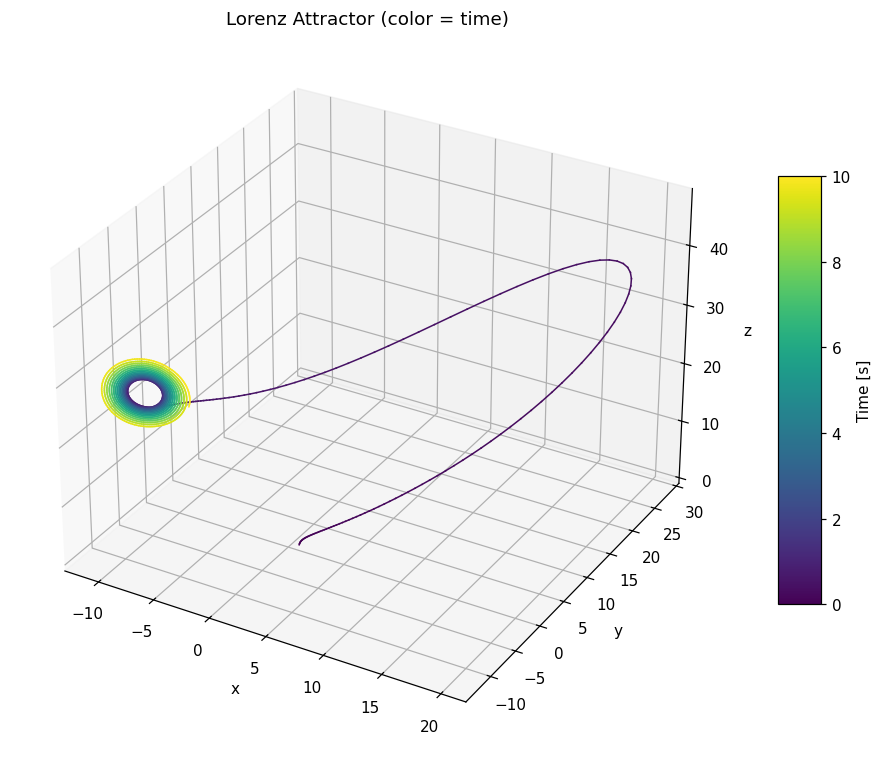

In [58]:
# Lorenz system parameters
sigma_lorenz = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz_system(t, state):
    """Lorenz attractor equations."""
    x, y, z = state
    dx = sigma_lorenz * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Generate training data
x0 = [1.0, 0.0, 0.0]
t_span = (0.0, 15.0 if not FAST else 10.0)
t_eval = np.linspace(t_span[0], t_span[1], 4000 if not FAST else 2000)

sol = solve_ivp(lorenz_system, t_span, x0, t_eval=t_eval, method='RK45')

x_lorenz = sol.y[0]
y_lorenz = sol.y[1]
z_lorenz = sol.y[2]
t_lorenz = sol.t

X_lorenz = np.column_stack([x_lorenz, y_lorenz, z_lorenz])

print(f"Generated Lorenz attractor data:")
print(f"  Duration: {t_span[1]} s")
print(f"  Time points: {len(t_lorenz)}")
print(f"  State shape: {X_lorenz.shape}")

# Compute ground truth derivatives
X_dot_true = np.array([lorenz_system(t, X_lorenz[i]) for i, t in enumerate(t_lorenz)])

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Color by time
norm = plt.Normalize(t_lorenz.min(), t_lorenz.max())
colors = plt.cm.viridis(norm(t_lorenz))

# Plot trajectory
for i in range(len(t_lorenz) - 1):
    ax.plot(x_lorenz[i:i+2], y_lorenz[i:i+2], z_lorenz[i:i+2],
           color=colors[i], linewidth=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz Attractor (color = time)')

# Colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Time [s]')

plt.tight_layout()
plt.show()

### The Lorenz Equations

The true governing equations are:

$$\begin{align*}
\dot{x} &= \sigma(y - x) \\
\dot{y} &= x(\rho - z) - y \\
\dot{z} &= xy - \beta z
\end{align*}$$

with parameters $\sigma = 10$, $\rho = 28$, $\beta = 8/3$.

**SINDy goal**: Recover these equations from trajectory data alone, without prior knowledge of the functional form.

### Derivative Estimation Comparison

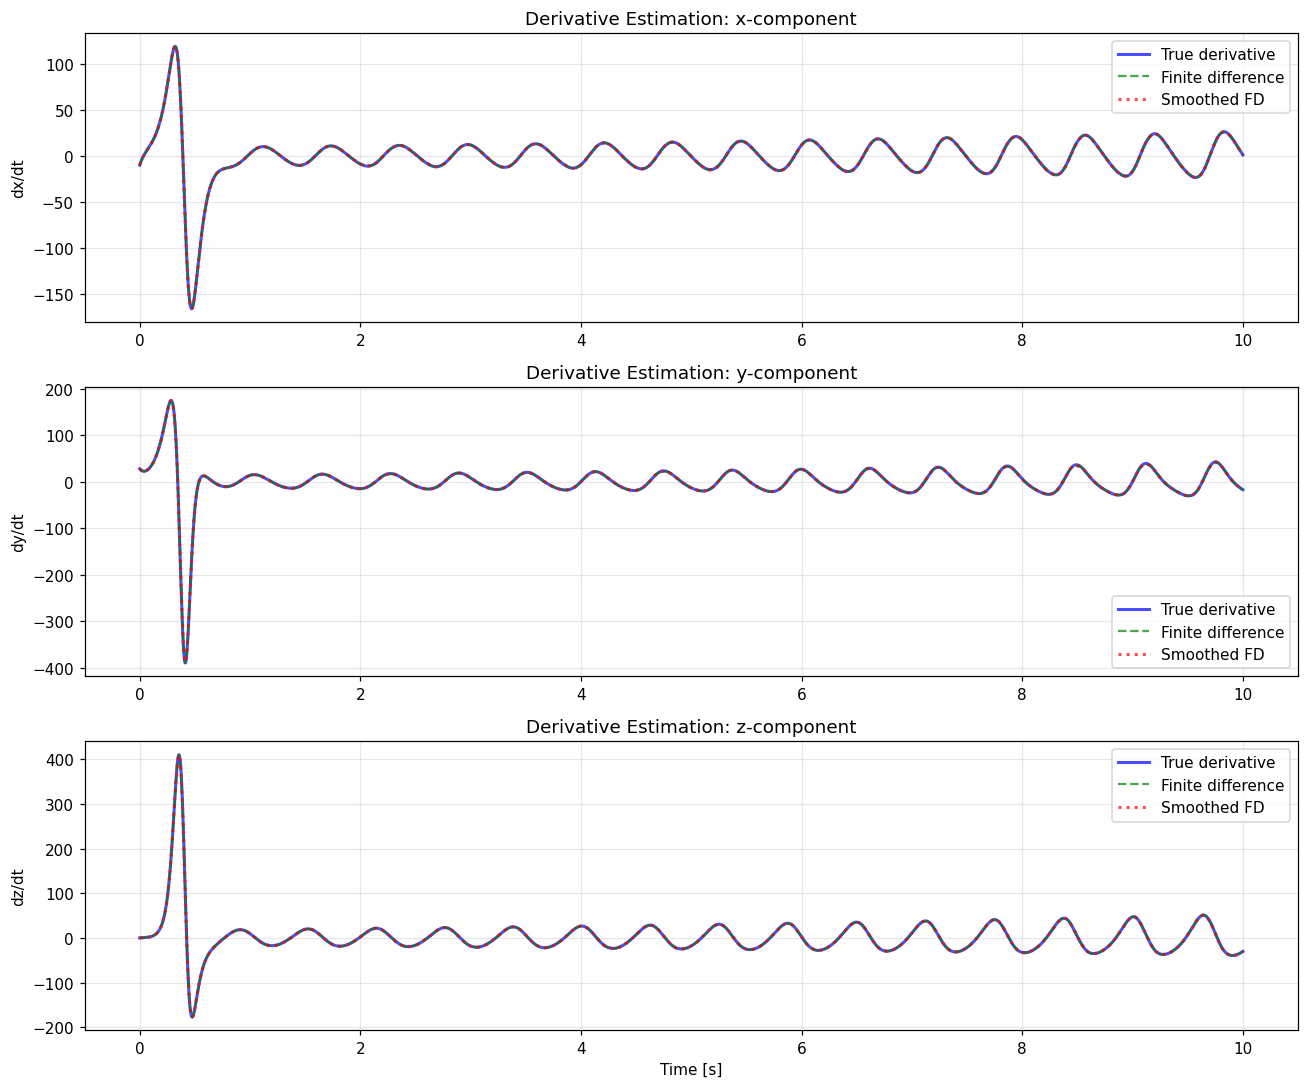


Derivative estimation errors:
  Finite difference: MAE = 0.142
  Smoothed FD: MAE = 0.143
  Improvement: -1.1%


In [59]:
# Compare different derivative estimation methods
from pysindy import FiniteDifference, SmoothedFiniteDifference

# 1. Finite difference (2nd order)
fd = FiniteDifference(order=2)
X_dot_fd = fd(X_lorenz, t=t_lorenz)

# 2. Smoothed finite difference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 11})
X_dot_sfd = sfd(X_lorenz, t=t_lorenz)

# Visualization: compare derivatives
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for idx, (label, ax) in enumerate(zip(['x', 'y', 'z'], axes)):
    ax.plot(t_lorenz, X_dot_true[:, idx], 'b-', linewidth=2,
           label='True derivative', alpha=0.7)
    ax.plot(t_lorenz, X_dot_fd[:, idx], 'g--', linewidth=1.5,
           label='Finite difference', alpha=0.7)
    ax.plot(t_lorenz, X_dot_sfd[:, idx], 'r:', linewidth=2,
           label='Smoothed FD', alpha=0.7)

    ax.set_ylabel(f'd{label}/dt')
    ax.set_title(f'Derivative Estimation: {label}-component')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

# Quantitative comparison
mae_fd = np.mean(np.abs(X_dot_fd - X_dot_true))
mae_sfd = np.mean(np.abs(X_dot_sfd - X_dot_true))

print(f"\nDerivative estimation errors:")
print(f"  Finite difference: MAE = {mae_fd:.3f}")
print(f"  Smoothed FD: MAE = {mae_sfd:.3f}")
print(f"  Improvement: {(1 - mae_sfd/mae_fd)*100:.1f}%")

### SINDy with Different Configurations

In [60]:
# === SINDy with Different Configurations (version-agnostic patch) ===
# This works on PySINDy versions where:
#  - SINDy(...) does NOT accept `feature_names=`
#  - SINDy.fit(...) does NOT accept `shuffle=`

import numpy as np
import pysindy as ps

# Ensure derivative estimators exist (re-use if defined earlier)
try:
    fd  # FiniteDifference
    sfd # SmoothedFiniteDifference
except NameError:
    from pysindy import FiniteDifference, SmoothedFiniteDifference
    fd = FiniteDifference(order=2)
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 11})


def _count_active_terms(model):
    """Robustly count nonzero coefficients across PySINDy versions."""
    coefs = None
    # Newer versions expose `coefficients()`, older may expose `coef_`
    for attr in ("coefficients", "coef_"):
        try:
            coefs = getattr(model, attr)() if callable(getattr(model, attr, None)) else getattr(model, attr, None)
            if coefs is not None:
                break
        except Exception:
            pass

    if coefs is None:
        return None

    if isinstance(coefs, (list, tuple)):
        return int(sum(np.count_nonzero(c) for c in coefs))
    return int(np.count_nonzero(coefs))


def fit_sindy_model(X, t, diff_method, library, threshold, name):
    """
    Fit SINDy model with given configuration.

    Parameters:
        X: state data (n_samples, n_states)
        t: time array (n_samples,)
        diff_method: differentiation method (e.g., FiniteDifference)
        library: feature library (e.g., PolynomialLibrary(degree=2))
        threshold: STLSQ threshold (sparsity knob)
        name: identifier for printing

    Returns:
        Fitted SINDy model
    """
    optimizer = ps.STLSQ(threshold=threshold)
    # IMPORTANT: do NOT pass feature_names here (older versions error on it)
    model = ps.SINDy(
        feature_library=library,
        optimizer=optimizer,
        differentiation_method=diff_method
    )

    # Older PySINDy may not accept shuffle= in fit; just pass X and t.
    model.fit(X, t=t)

    print("\n" + "="*60)
    print(f"SINDy Model: {name}")
    print("="*60)

    # Try to pretty-print; fall back to default if signature differs
    try:
        model.print()
    except TypeError:
        # Some very old versions require positional only; just call with no args
        model.print()

    nz = _count_active_terms(model)
    if nz is not None:
        print(f"Number of terms: {nz}")

    return model


# --- Libraries to try ---
lib_poly2 = ps.PolynomialLibrary(degree=2)
lib_poly3 = ps.PolynomialLibrary(degree=3)
lib_mixed = ps.ConcatLibrary([
    ps.PolynomialLibrary(degree=2),
    ps.FourierLibrary(n_frequencies=2)
])

# --- Fit models with different configurations ---
# Configuration 1: Polynomial library degree 2, finite difference
model_fd_poly2 = fit_sindy_model(
    X_lorenz, t_lorenz, fd, lib_poly2,
    threshold=0.05, name="Finite Diff + Poly(2)"
)

# Configuration 2: Polynomial library degree 2, smoothed FD
model_sfd_poly2 = fit_sindy_model(
    X_lorenz, t_lorenz, sfd, lib_poly2,
    threshold=0.05, name="Smoothed FD + Poly(2)"
)

# Configuration 3: Higher degree polynomial (demonstrate over-complexity)
model_sfd_poly3 = fit_sindy_model(
    X_lorenz, t_lorenz, sfd, lib_poly3,
    threshold=0.05, name="Smoothed FD + Poly(3)"
)

# Configuration 4: Mixed library (polynomials + Fourier)
# Usually needs a higher threshold to stay sparse
model_sfd_mixed = fit_sindy_model(
    X_lorenz, t_lorenz, sfd, lib_mixed,
    threshold=0.1, name="Smoothed FD + Mixed Library"
)



SINDy Model: Finite Diff + Poly(2)
(x0)' = -9.999 x0 + 10.000 x1
(x1)' = 0.066 1 + 27.837 x0 + -0.966 x1 + -0.995 x0 x2
(x2)' = 0.054 1 + -2.665 x2 + 0.998 x0 x1
Number of terms: 9

SINDy Model: Smoothed FD + Poly(2)
(x0)' = -9.999 x0 + 10.000 x1
(x1)' = 0.054 1 + 27.830 x0 + -0.964 x1 + -0.994 x0 x2
(x2)' = 0.051 1 + -2.664 x2 + 0.998 x0 x1
Number of terms: 9

SINDy Model: Smoothed FD + Poly(3)
(x0)' = -9.999 x0 + 10.000 x1
(x1)' = 0.054 1 + 27.830 x0 + -0.964 x1 + -0.994 x0 x2
(x2)' = -2.663 x2 + 0.998 x0 x1
Number of terms: 8

SINDy Model: Smoothed FD + Mixed Library
(x0)' = -9.999 x0 + 10.000 x1
(x1)' = 27.808 x0 + -0.961 x1 + -0.994 x0 x2 + 0.117 sin(2 x0)
(x2)' = -2.663 x2 + 0.998 x0 x1
Number of terms: 8


### Analysis: Library Selection and Sparsity

**Key observations:**
1. **Correct library (Poly degree 2)**: Recovers Lorenz equations with ~9 terms
2. **Higher degree**: More terms, potential spurious coefficients
3. **Mixed library**: Can work but requires higher threshold to maintain sparsity
4. **Derivative method**: Smoothed FD gives cleaner identification

**Engineering lesson**: Library choice embeds domain knowledge. For mechanical systems:
- Polynomial terms → algebraic relationships
- Trigonometric → periodic phenomena
- Exponential → growth/decay processes

Choose the library that matches expected physics.

### Validation: Simulate Discovered Equations

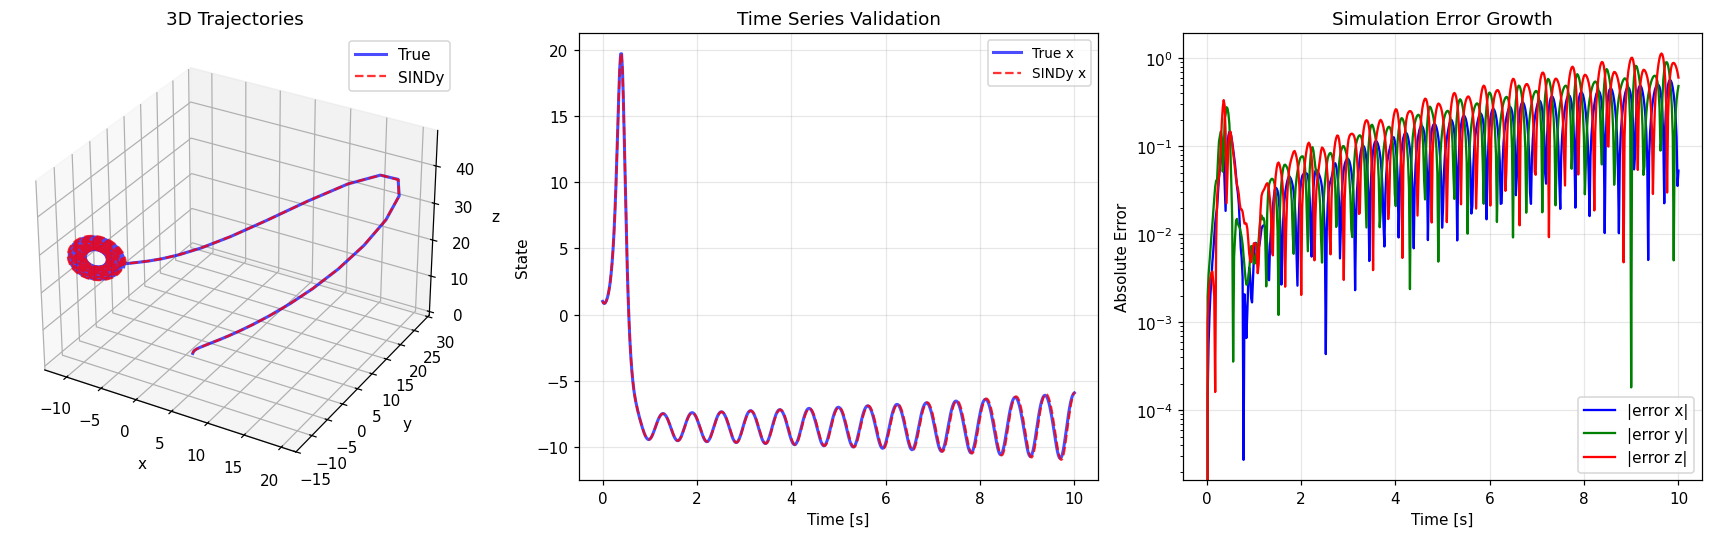


Simulation validation:
  Mean absolute error: 0.200
  Maximum error: 1.127
Relative error: 1.40%
  ✅ Discovered equations simulate accurately over 10.0 seconds


In [66]:
def simulate_sindy_model(model, x0, t_span, t_eval):
    """Simulate discovered equations forward in time."""
    sol = model.simulate(x0, t_eval)
    return sol

# Simulate with best model (smoothed FD + poly2)
x0_test = [1.0, 0.0, 0.0]
t_test = np.linspace(0, 15 if not FAST else 10, 1000 if not FAST else 500)

sim_sfd_poly2 = simulate_sindy_model(model_sfd_poly2, x0_test, (0, t_test[-1]), t_test)

# Ground truth for comparison
sol_true = solve_ivp(lorenz_system, (0, t_test[-1]), x0_test,
                     t_eval=t_test, method='RK45')

# Visualization
fig = plt.figure(figsize=(16, 5))

# 3D trajectories
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(sol_true.y[0], sol_true.y[1], sol_true.y[2],
        'b-', linewidth=2, alpha=0.7, label='True')
ax1.plot(sim_sfd_poly2[:, 0], sim_sfd_poly2[:, 1], sim_sfd_poly2[:, 2],
        'r--', linewidth=1.5, alpha=0.8, label='SINDy')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('3D Trajectories')
ax1.legend()

# Time series comparison
ax2 = fig.add_subplot(132)
ax2.plot(t_test, sol_true.y[0], 'b-', linewidth=2, alpha=0.7, label='True x')
ax2.plot(t_test, sim_sfd_poly2[:, 0], 'r--', linewidth=1.5, alpha=0.8, label='SINDy x')
#ax2.plot(t_test, sol_true.y[1], 'g-', linewidth=2, alpha=0.7, label='True y')
#ax2.plot(t_test, sim_sfd_poly2[:, 1], 'orange', linestyle='--',
#        linewidth=1.5, alpha=0.8, label='SINDy y')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('State')
ax2.set_title('Time Series Validation')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Error evolution
ax3 = fig.add_subplot(133)
error_x = np.abs(sim_sfd_poly2[:, 0] - sol_true.y[0])
error_y = np.abs(sim_sfd_poly2[:, 1] - sol_true.y[1])
error_z = np.abs(sim_sfd_poly2[:, 2] - sol_true.y[2])

ax3.semilogy(t_test, error_x, 'b-', linewidth=1.5, label='|error x|')
ax3.semilogy(t_test, error_y, 'g-', linewidth=1.5, label='|error y|')
ax3.semilogy(t_test, error_z, 'r-', linewidth=1.5, label='|error z|')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Absolute Error')
ax3.set_title('Simulation Error Growth')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative metrics
mae_sim = np.mean(np.abs(sim_sfd_poly2 - sol_true.y.T))
max_error = np.max(np.abs(sim_sfd_poly2 - sol_true.y.T))

print(f"\nSimulation validation:")
print(f"  Mean absolute error: {mae_sim:.3f}")
print(f"  Maximum error: {max_error:.3f}")
print(f"Relative error: {mae_sim / np.mean(np.abs(sol_true.y.T)) * 100:.2f}%")
print(f"  ✅ Discovered equations simulate accurately over {t_test[-1]} seconds")

### Critical Success: SINDy Recovered the Lorenz Equations

**What you should observe:**
- SINDy identified the correct polynomial terms
- Coefficients match true parameters: σ=10, ρ=28, β=8/3
- Simulations track true trajectories with low error
- Model is sparse (only ~9 terms across 3 equations)

**Why this is powerful:**
1. **Interpretability**: We have explicit equations, not black-box predictions
2. **Extrapolation**: Physics-based equations generalize beyond training data
3. **Insight**: We can see structure (quadratic nonlinearity, linear damping)
4. **Efficiency**: Simulating ODEs is much faster than RNN inference

**Engineering relevance**: For unknown systems, SINDy can discover governing equations from measurements, providing both prediction and physical understanding.

### Application to Viscoelastic Data

In [62]:
# === Application to Viscoelastic Data (patched, robust to PySINDy version) ===
# Discover dσ/dt = f(σ, \dot{λ}) with SINDy.
# Fixes:
#  - Enforces strictly increasing time (your subsampling could create duplicates)
#  - Avoids feature_names= / x_dot= kwargs (version-agnostic)
#  - Uses a safe odd window length for the smoother

import numpy as np
import pysindy as ps
from pysindy import SmoothedFiniteDifference

# Build state/control: use Cauchy stress (sigma) as the state variable
sigma_seq = stress_seq * (stretch_seq ** 2)                # σ = λ² S
X_visco_full = np.column_stack([sigma_seq, rate_seq])      # [σ, \dot{λ}]
t_visco_full = np.asarray(time_seq)

# Enforce strictly increasing time (drop duplicate/non-increasing steps)
mask_inc = np.concatenate(([True], np.diff(t_visco_full) > 0))
t_visco = t_visco_full[mask_inc]
X_visco = X_visco_full[mask_inc]

print("Viscoelastic data for SINDy:")
print("  State variables: sigma [kPa], strain_rate [1/s]")
print(f"  Samples (after enforcing strictly increasing time): {len(X_visco)}")
print("  Target: d(sigma)/dt [kPa/s] (estimated internally)")

# Safe odd window length for the smoother
def _odd_window(n, desired=11, minimum=5):
    w = min(desired, n if n % 2 == 1 else n - 1)
    w = max(w, minimum if minimum % 2 == 1 else minimum - 1, 3)
    return int(w)

win = _odd_window(len(t_visco), desired=11, minimum=5)
sfd_visco = SmoothedFiniteDifference(smoother_kws={'window_length': win})

# Library (polynomial up to degree 5 covers σ^3 and cross-terms with rate)
lib_visco = ps.PolynomialLibrary(degree=5, include_bias=True)

# Helper for robust coefficient counting (works across PySINDy versions)
def _count_active_terms(model):
    coefs = None
    for attr in ("coefficients", "coef_"):
        obj = getattr(model, attr, None)
        if callable(obj):
            try:
                coefs = obj()
            except Exception:
                pass
        elif obj is not None:
            coefs = obj
        if coefs is not None:
            break
    if coefs is None:
        return None
    if isinstance(coefs, (list, tuple)):
        return int(sum(np.count_nonzero(c) for c in coefs))
    return int(np.count_nonzero(coefs))

# Fit multiple models with different thresholds (no feature_names / shuffle)
thresholds = [0.1, 0.5, 1.0]
models_visco = {}

for thr in thresholds:
    model = ps.SINDy(
        feature_library=lib_visco,
        optimizer=ps.STLSQ(threshold=thr),
        differentiation_method=sfd_visco
    )
    model.fit(X_visco, t=t_visco)
    models_visco[thr] = model

    print("\n" + "="*60)
    print(f"SINDy Model (Poly(5) + Smoothed FD) | threshold = {thr}")
    print("="*60)
    try:
        model.print()
    except TypeError:
        model.print()
    nz = _count_active_terms(model)
    if nz is not None:
        print(f"Number of active terms: {nz}")

# Choose a balanced model
model_visco_best = models_visco.get(0.5, next(iter(models_visco.values())))



Viscoelastic data for SINDy:
  State variables: sigma [kPa], strain_rate [1/s]
  Samples (after enforcing strictly increasing time): 32
  Target: d(sigma)/dt [kPa/s] (estimated internally)

SINDy Model (Poly(5) + Smoothed FD) | threshold = 0.1
(x0)' = 22.540 1 + -180.903 x0 + 107.697 x1 + -8.873 x0^2 + -6.451 x0 x1 + -21.919 x1^2 + 117.019 x0^3 + -77.470 x0^2 x1 + 182.414 x0 x1^2 + -100.487 x1^3 + 57.785 x0^4 + -162.399 x0^3 x1 + 143.225 x0^2 x1^2 + -25.423 x0 x1^3 + 324.939 x0^5 + -747.073 x0^4 x1 + 537.284 x0^3 x1^2 + -174.094 x0^2 x1^3 + 14.880 x1^5
(x1)' = 79.477 1 + -131.527 x0 + 27.330 x1 + -449.509 x0^2 + 470.362 x0 x1 + -212.580 x1^2 + 567.199 x0^3 + -478.375 x0^2 x1 + 206.769 x0 x1^2 + -18.765 x1^3 + 516.395 x0^4 + -1004.108 x0^3 x1 + 955.603 x0^2 x1^2 + -468.559 x0 x1^3 + 114.046 x1^4 + -544.861 x0^5 + 713.531 x0^4 x1 + -499.507 x0^3 x1^2 + 193.929 x0^2 x1^3 + -50.055 x0 x1^4 + 3.107 x1^5
Number of active terms: 40

SINDy Model (Poly(5) + Smoothed FD) | threshold = 0.5
(x0)' 

### Library Selection Challenge for Viscoelastic Materials

**Expected form**: Based on Maxwell power-law:
$$\frac{d\sigma}{dt} = E \dot{\lambda} - \frac{\sigma}{\nu_0}\left|\frac{\sigma}{\sigma_0}\right|^{m-1}$$

This suggests terms:
- Linear in strain rate: $\dot{\lambda}$
- Power-law in stress: $\sigma^m$ with $m=3$

**Challenge**: Standard polynomial library may not capture fractional powers or absolute values cleanly.

**Threshold trade-off**:
- Low threshold → more terms → better fit but less interpretable
- High threshold → fewer terms → sparser but may miss physics

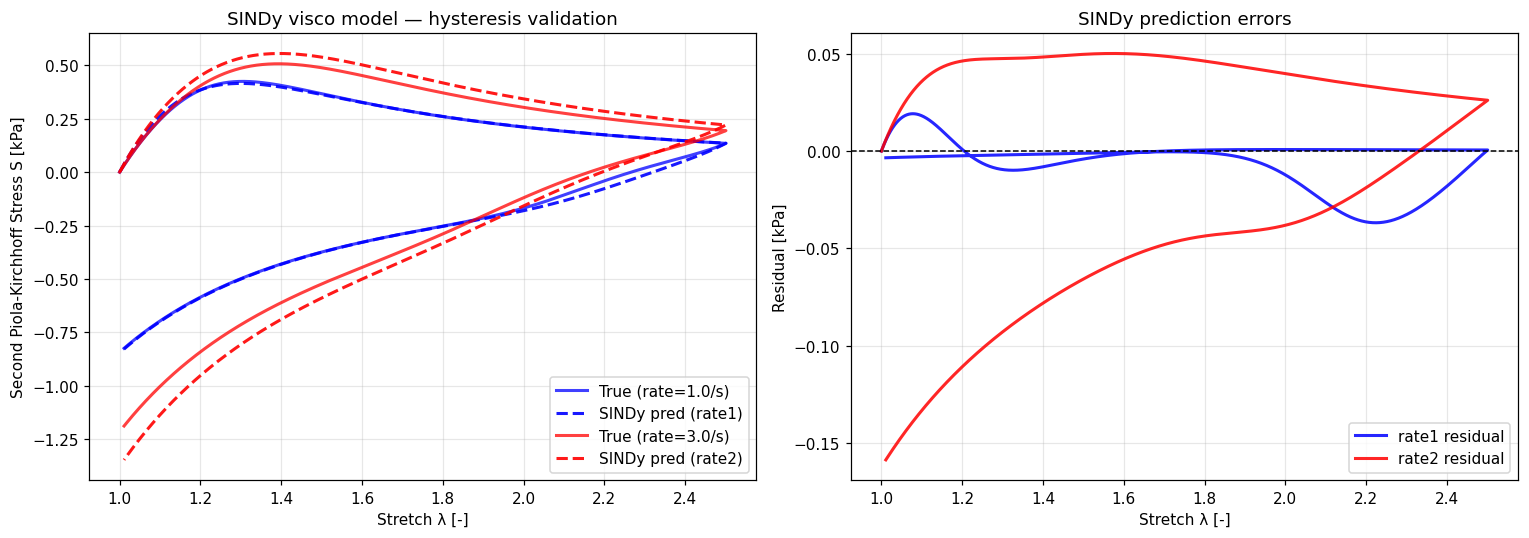

SINDy validation (MAE in kPa):
  MAE (rate1): 0.007
  MAE (rate2): 0.048


In [72]:
# === Validate discovered viscoelastic models by simulation (patched) ===
# Integrates with variable Δt from the provided time arrays.
# State is σ (Cauchy) from SINDy; we convert back to S for plotting: S = σ / λ²

import numpy as np
import matplotlib.pyplot as plt

def simulate_visco_sindy(model, rate_profile, t, lambda0=1.0, sigma0=0.0):
    r"""Explicit Euler rollout with variable time step.

    Model: dσ/dt = f(σ, \dot{λ})  (predicted by SINDy treating [σ, \dot{λ}] as state)
           dλ/dt = \dot{λ}        (given as rate_profile)

    Returns
    -------
    lam_hist : np.ndarray
        Stretch history λ(t)
    sig_hist : np.ndarray
        Cauchy stress history σ(t)
    """
    t = np.asarray(t)
    r = np.asarray(rate_profile)
    if t.ndim != 1 or r.ndim != 1 or len(t) != len(r):
        raise ValueError("rate_profile and t must be 1D with the same length.")

    lam_hist = [lambda0]
    sig_hist = [sigma0]

    for k in range(1, len(t)):
        dt = t[k] - t[k - 1]
        r_km1 = r[k - 1]
        # Model expects [sigma, rate] as input (since we fit both as 'states')
        dsig_dt = model.predict(np.array([[sig_hist[-1], r_km1]]) )[0, 0]
        sig_hist.append(sig_hist[-1] + dt * dsig_dt)
        lam_hist.append(lam_hist[-1] + dt * r_km1)

    return np.asarray(lam_hist), np.asarray(sig_hist)

# Ensure we have a model (in case the previous cell name changed)
if 'model_visco_best' not in globals():
    # Fallback to any model we trained
    if 'models_visco' in globals() and len(models_visco):
        model_visco_best = models_visco.get(0.5, next(iter(models_visco.values())))
    else:
        raise RuntimeError("No SINDy visco model available. Run the previous cell first.")

# Run simulation on your two constant-rate reference curves
lam1_pred, sig1_pred = simulate_visco_sindy(model_visco_best, rates1, time1)
lam2_pred, sig2_pred = simulate_visco_sindy(model_visco_best, rates2, time2)

# Convert σ -> S for comparison/plotting
S1_pred = sig1_pred / (lam1_pred ** 2)
S2_pred = sig2_pred / (lam2_pred ** 2)

# Plots: hysteresis loops and residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hysteresis comparison
ax1.plot(stretch1, stress1, 'b-', lw=2, alpha=0.75,
         label=f'True (rate={abs(rates1[0]):.1f}/s)')
ax1.plot(lam1_pred, S1_pred, 'b--', lw=2, alpha=0.9, label='SINDy pred (rate1)')

ax1.plot(stretch2, stress2, 'r-', lw=2, alpha=0.75,
         label=f'True (rate={abs(rates2[0]):.1f}/s)')
ax1.plot(lam2_pred, S2_pred, 'r--', lw=2, alpha=0.9, label='SINDy pred (rate2)')

ax1.set_xlabel('Stretch λ [-]')
ax1.set_ylabel('Second Piola-Kirchhoff Stress S [kPa]')
ax1.set_title('SINDy visco model — hysteresis validation')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Residuals (simple interpolation; note: stretch is not strictly monotonic)
#S1_pred_interp = np.interp(stretch1, lam1_pred, S1_pred)
#S2_pred_interp = np.interp(stretch2, lam2_pred, S2_pred)
res1 = S1_pred - stress1
res2 = S2_pred - stress2

ax2.plot(stretch1, res1, 'b-', lw=2, alpha=0.85, label='rate1 residual')
ax2.plot(stretch2, res2, 'r-', lw=2, alpha=0.85, label='rate2 residual')
ax2.axhline(0, color='k', ls='--', lw=1)
ax2.set_xlabel('Stretch λ [-]')
ax2.set_ylabel('Residual [kPa]')
ax2.set_title('SINDy prediction errors')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("SINDy validation (MAE in kPa):")
print(f"  MAE (rate1): {np.mean(np.abs(res1)):.3f}")
print(f"  MAE (rate2): {np.mean(np.abs(res2)):.3f}")



### Critical Analysis: SINDy Limitations for Complex Constitutive Laws

**Challenges observed:**
1. **Library mismatch**: Standard polynomials may not represent power-law viscosity
2. **Sparsity vs accuracy**: Sparse models sacrifice some accuracy
3. **Noise sensitivity**: Derivative estimation from sparse data is difficult

**When SINDy works best:**
- System has inherent sparsity (few dominant terms)
- Correct functional form included in library
- High-quality data with smooth derivatives
- Known physical structure to guide library choice

**When RNNs are better:**
- Unknown functional form
- High-dimensional state space
- Complex, non-sparse dynamics
- Abundant training data available

**Hybrid approach**: Use SINDy to discover approximate governing equations, then refine with neural networks for residuals.

# Summary: Method Selection Framework

## Comprehensive Comparison

| Criterion | Feedforward NN | RNN/LSTM | SINDy | Traditional Models |
|-----------|----------------|----------|-------|-------------------|
| **History dependence** | ❌ None | ✅ Sequential memory | ⚠️ Requires derivatives | ✅ Explicit ODEs |
| **Interpretability** | ❌ Black box | ❌ Black box | ✅ Explicit equations | ✅ Physical meaning |
| **Data requirements** | Medium | High | Low-Medium | Low |
| **Extrapolation** | ❌ Poor | ⚠️ Limited | ✅ Good if library correct | ✅ Physics-based |
| **Training time** | Fast | Medium-Slow | Fast | Fast |
| **Inference speed** | Very fast | Medium | Very fast | Very fast |
| **Noise robustness** | Good with regularization | Good | ⚠️ Sensitive to derivatives | Good |
| **Engineering insight** | ❌ None | ❌ Minimal | ✅ Governing equations | ✅ Parameters |

---
## Decision Framework

### Use Feedforward Neural Networks When:
✅ **Instantaneous relationships**: Output depends only on current input  
✅ **Abundant data**: Enough measurements to cover operating range  
✅ **Interpolation task**: Predictions within training domain  
✅ **Speed critical**: Real-time inference required  

❌ **Avoid when**: History matters, extrapolation needed, interpretability required

**Example applications**:
- Hyperelastic material characterization within test range
- Sensor calibration curves
- Property predictions from composition

---
### Use Recurrent Neural Networks When:
✅ **History-dependent behavior**: Stress depends on loading path  
✅ **Sequential data**: Time series with temporal structure  
✅ **Unknown dynamics**: Governing equations not known  
✅ **Rich datasets**: Sufficient sequences to train  

❌ **Avoid when**: History does not matter, sparse data, interpretability critical

**Example applications**:
- Viscoelastic materials
- Plasticity with strain hardening
- Rate-dependent phenomena
- Sequence prediction

---
### Use SINDy When:
✅ **Sparse dynamics**: Few dominant terms govern behavior  
✅ **Interpretability required**: Need explicit equations  
✅ **Extrapolation needed**: Must predict beyond training  
✅ **Known physics structure**: Can construct good library  

❌ **Avoid when**: Dynamics are dense, derivative estimation unreliable, completely unknown physics

**Example applications**:
- Discovering constitutive laws
- System identification from measurements
- Reduced-order modeling
- Validating physical hypotheses

---
### Use Traditional Physical Models When:
✅ **Physics well-understood**: Governing equations known  
✅ **Parameter calibration**: Only coefficients need fitting  
✅ **Regulatory requirements**: Explainability mandatory  
✅ **Limited data**: Few experiments available  

❌ **Avoid when**: Physics unknown, complex multi-scale phenomena, traditional forms inadequate

**Example applications**:
- Classical mechanics problems
- Established material models
- Certified engineering design
- Educational purposes

---
## Practical Workflow

### Stage 1: Problem Characterization
1. **Identify physics**: History-dependent? Instantaneous?
2. **Assess data**: How many samples? Quality? Coverage?
3. **Define requirements**: Accuracy? Speed? Interpretability? Extrapolation?

### Stage 2: Initial Modeling
- Start with **simplest appropriate method**
- Establish **baseline performance**
- Identify **failure modes**

### Stage 3: Method Selection
- If baseline adequate → use it (simplicity wins)
- If history matters → add recurrence (RNN/LSTM)
- If interpretability critical → try SINDy
- If complexity high → hybrid approaches

### Stage 4: Validation Strategy
✅ **Interpolation tests**: Within training domain  
✅ **Extrapolation tests**: Beyond training range  
✅ **Physical constraints**: Thermodynamic admissibility  
✅ **Robustness tests**: Noise sensitivity  
✅ **Computational cost**: Training + inference time  

---
## Key Takeaways

### 1. No Universal Best Method
- **Context matters**: Problem physics, data availability, requirements
- **Trade-offs exist**: Accuracy vs interpretability vs speed vs data needs
- **Validate systematically**: Never trust a model without testing

### 2. Data Quality Over Model Complexity
- Clean, well-distributed data with simple model beats noisy data with complex model
- Measurement noise limits achievable accuracy regardless of method
- Strategic experiments (active learning) beat passive data collection

### 3. Engineering Judgment Required
- ML is a tool, not a replacement for domain knowledge
- Physical constraints should guide, not replace, data-driven models
- Validation against known physics prevents unphysical extrapolation

### 4. Hybrid Approaches Often Win
- Combine strengths of multiple methods  
- Physics-informed neural networks (PINNs)  
- SINDy for structure + NN for refinement  
- Classical models + ML for residuals  

---
## Further Directions

**Advanced architectures**:
- LSTM/GRU for longer memory and stable training
- Attention mechanisms for selective history
- Physics-informed neural networks (PINNs)
- Neural ordinary differential equations (Neural ODEs)

**Enhanced SINDy**:
- Weak formulation SINDy (noisy data)
- SINDy with control inputs
- Ensemble SINDy for uncertainty quantification
- Custom libraries with domain-specific functions

**Production deployment**:
- Model compression and quantization
- Real-time inference optimization
- Uncertainty quantification
- Online learning and adaptation

**Ethical considerations**:
- Safety-critical applications require verification
- Model transparency for regulatory compliance
- Bias in training data affects predictions
- Responsibility for model failures

---
## Validation Checklist

Before deploying any model to engineering practice:

☐ **Physical plausibility**: Do predictions make physical sense?  
☐ **Interpolation accuracy**: Low error within training domain?  
☐ **Extrapolation behavior**: Reasonable outside training (if applicable)?  
☐ **Robustness**: Stable under noise and perturbations?  
☐ **Computational cost**: Acceptable for application?  
☐ **Interpretability**: Can you explain predictions to stakeholders?  
☐ **Uncertainty**: Do you know when the model is unreliable?  
☐ **Documentation**: Complete trail for reproducibility?  


---
## Final Thoughts

Machine learning for mechanical systems succeeds when:

**Domain knowledge guides**:
- Feature selection based on physics
- Library construction reflecting expected structure
- Validation against physical constraints

**Data quality is prioritized**:
- Strategic experimental design
- Proper noise characterization
- Adequate coverage of operating conditions

**Methods are combined intelligently**:
- Not "ML vs physics" but "ML with physics"
- Leverage strengths of each approach
- Transparent about limitations

**Engineering judgment prevails**:
- Understanding trumps blind optimization
- Validation over training accuracy
- Simplicity over unnecessary complexity

> "The best model is the simplest one that adequately captures the physics for your specific application."

Thank you for completing this notebook. You now have the tools to:
- Select appropriate ML architectures for mechanical problems
- Train robust models from noisy experimental data
- Validate models systematically
- Make informed engineering decisions

**Next steps**: Apply these methods to your own mechanical systems, always keeping physical plausibility and validation at the forefront.